### ST455 Summative
## Learning Optimal Racing Lines in Discrete Space: A Single and Multi-Agent Reinforcement Learning Approach
### **Authors:** 48693 & 49834
### May 5, 2025

### **Abstract**

In this project, we investigate the use of reinforcement learning (RL) to learn optimal racing trajectories in a discrete-space racetrack environment. The core problem is to enable agents to complete laps around a track in the fewest steps possible while avoiding crashes and adhering to track constraints. This is an essential challenge in autonomous driving and competitive racing simulations. We develop a custom RL environment and apply a range of temporal-difference (TD) learning algorithms, including SARSA, Q-Learning, SARSA($\lambda$), and Double Q-Learning, to evaluate their effectiveness in learning efficient policies.

Through extensive training and optimisation, including grid searches over key hyperparameters, we identify SARSA($\lambda$) with $\lambda \approx 0.5$ as the most effective single-agent solution. To explore interactive dynamics, we extend our framework to a multi-agent setting using the Independent Learners paradigm, highlighting the challenges of non-stationarity in multi-agent RL. Our results demonstrate the feasibility of learning realistic racing behaviours, such as corner apexing, and reveal the trade-offs between exploration strategies, learning stability, and environmental design. This work contributes to the broader study of RL-based navigation and lays the groundwork for future extensions to more realistic or adversarial racing settings.

### **1 Introduction**

Autonomous racing and robotic navigation demand agents that can plan time-optimal trajectories under complex dynamic constraints. In this project, we investigate whether reinforcement learning (RL) agents can learn such strategies within a custom-designed, discrete-state racing environment. The goal is to develop control policies that enable agents to complete laps efficiently and with minimal steps, effectively approximating the optimal racing line.

Our investigation begins with optimising single-agent learning, where we evaluate a variety of temporal-difference (TD) algorithms, exploring how elements like exploration decay, eligibility traces, and reward design influence learning outcomes. To further challenge our agents and reflect real-world racing scenarios, we extend our setting to support multiple agents competing on the same track. This competitive multi-agent setting introduces additional complexity, requiring agents not only to optimize their own trajectories, but also to account for the behaviour and positioning of opponents, mimicking the strategic depth of real racing environments.

### **2 Methodology**

#### **2.1: Single-Agent Reinforcement Learning Approach**

In this discrete case, we consider an environment inspired by a classic pencil-and-paper mathematics game known as "Racetrack." Here, a track is formed on a quadrille grid, which defines the admissible state space. The racer, represented as a single point on this grid, must navigate around the track by selecting actions at each discrete timestep, subject to specific restrictions.

In particular, each action corresponds to an acceleration vector: based on the racer's previous velocity vector, it may maintain its current velocity or adjust it by one unit along any of the eight neighboring grid directions. This dynamic simulates a discrete analogue of physics-based movement, where the agent must accelerate to build speed and decelerate to avoid collisions with track boundaries.

Thus, the core objective becomes selecting a sequence of actions that minimizes the number of steps required to complete a lap, effectively identifying the optimal racing line within a discrete state-action space framework.

A notable piece of related literature is the work by Tingsong Ou (2023), who addresses in their article the classic racetrack exercise from *Reinforcement Learning: An Introduction* (Sutton and Barto, 2018, p.112) using an off-policy Monte Carlo Control approach with weighted importance sampling. Ou's implementation emphasises a comprehensive construction of the RL pipeline, including environment design, episodic task definition, action modelling, and algorithmic setup, and highlights the impact of value initialisation and task specification on performance. While their work serves as a strong reference for understanding Monte Carlo methods, **our project diverges by focusing on temporal difference (TD) learning algorithms**, particularly SARSA, Q-learning, Double Q-learning, and SARSA($\lambda$). Unlike the Monte Carlo paradigm, which relies on full returns and complete episodes, our approach emphasises incremental updates and bootstrapping, offering a more scalable foundation for environments with sparse rewards and extended trajectories, such as the racetrack domain explored here.

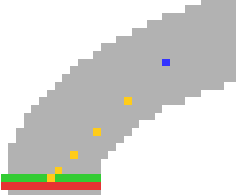

In [ ]:
from IPython import display
display.Image("pictures/Racetrack_acceleration_example.png")

*Example of acceleration.*

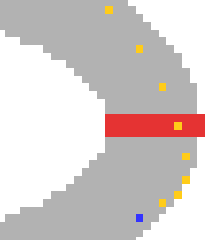

In [ ]:
display.Image("pictures/Racetrack_decceleration_example.png")

*Example of decceleration.* 

##### **2.1.1: Environment Design**

To formally describe and solve this problem within a Reinforcement Learning (RL) paradigm, we model the environment as a Markov Decision Process (MDP), whose formal definition is provided a few lines below.

We now formally describe the environment we construct: a discrete-time racing environment represented as a two-dimensional grid array, encoding the racetrack surface, track walls, starting area, and checkpoints. Each cell in this grid corresponds to a discrete state that the agent can occupy during navigation. For the purposes of visual demonstration and practicality, the **track we consider has quite a large state space** - the exact dimensions are "height=60, width=120, thickness=12".

The agent, modelled as a point mass, moves according to a velocity model: at each timestep, it selects an acceleration vector from a discrete set of actions. This modifies its current velocity, and the new velocity determines the agent’s next position on the grid, simulating simplified physics-based motion. Consequently, the problem naturally takes an episodic form, terminating when the agent either finishes the lap or crashes.

***Environment Layout***
- **Track**: A continuous closed loop formed by a filled elliptical shape on the grid, representing the racetrack surface where motion is permitted.
- **Walls**: All cells outside the defined track area act as implicit walls; exiting the track results in an immediate crash penalty and termination.
- **Start Line**: A strip of adjacent cells placed on the leftmost side of the oval track. For training efficiency, the agent begins from the midpoint of the start line. 
- **Checkpoints**: Four manually ordered checkpoint regions are placed symmetrically across the track (top-center, right-center, bottom-center, and left-center). Checkpoints must be passed sequentially. The final checkpoint doubles as the finish line.
- **Bresenham Line Algorithm**: To accurately detect whether the agent crosses checkpoint zones between discrete timesteps (especially at high speeds), we use the Bresenham Line algorithm (skimage.draw.line) to determine all intermediate cells traversed during motion.
- **Colour Mapping and Visualisation**:   
    - Track cells are shown as gray.
    - Start line cells as green.
    - Checkpoint cells as red (except the next active checkpoint, highlighted in orange).
    - The agent’s past trajectory is visualized in yellow, with the current agent position shown in blue.

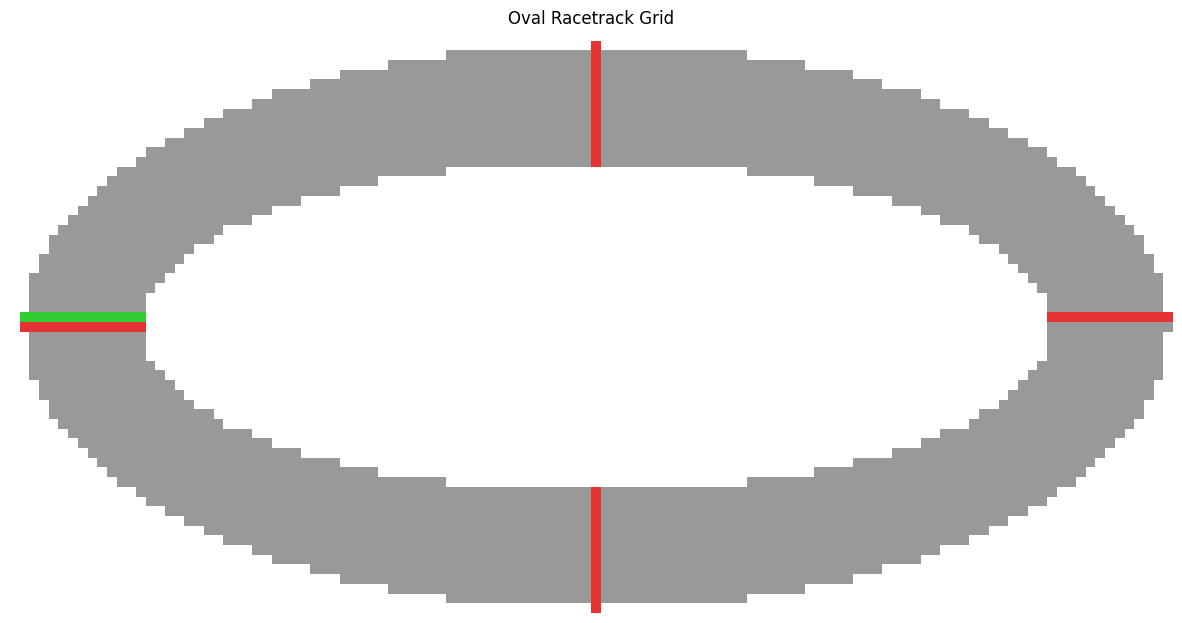

In [ ]:
display.Image(data="pictures/Racetrack_discrete_oval_grid.png", width=600, height=300)

*The oval-based track we consider for the discrete state-action space environment.*

**Markov Decision Processes (MDPs)** are used to formally represent a fully observable, stationary reinforcement learning environment. At each discrete time step t, an agent interacts with the environment, observing its current state, $S_t$. Based on this information, the agent applied an action, $A_t$, for which it recieves a reward, $R_t$. A finite MDP is characterized by a finite number of possible states (**S**), actions (**A**), and rewards (**R**) (Sutton and Barto, 2018). 

The Racetrack environment is a finite MDP whereby **S**, **A**, and **R** are defined as follows:
- **States**: This consists of the position (x, y) and velocity (v_x, v_y) of the car. The state space is finite because both the agent's position and velocity are constrained by the size of the grid.
- **Actions**: There are nine discrete actions, each corresponding to acceleration adjustments of (-1, 0, 1) along each axis (horizontal, vertical, and diagonal). Actions influence the agent's velocity, which in turn updates its position on the track. Additionally, we don't consider any constraints on velocity, as the track is such that decceleraton is inevitable, and we want agents to maximise their velocity as much as possible (like racers) on straighter paths.
- **Rewards**: The reward that the agent recieves is contingent on how the action contributes to its objective of completing a lap around the track. The reward structure has been tuned over multiple iterations of testing, in order to provide the agent with the right incentives to traverse the environment correctly and efficiently. In particular, we have the following:
    - *Progress Reward*: A positive reward proportional to the reduction in distance to the next checkpoint encourages consistent forward motion.
    - *Checkpoint Reward*: Passing through the correct sequential checkpoint provides a reward bonus of 20.
    - *Crash Penalty*: Leaving the track or colliding with walls results in a large negative reward of -100 and immediate episode termination.
    - *Step Penalty*: Each timestep incurs a small negative reward  of -2 to incentivize faster lap completions.
    - *Lap Completion Reward*: Upon passing through all checkpoints in order, a large final reward of 100 is granted, signifying successful lap completion.

    *Note: Special care is taken to penalize agents attempting to exploit checkpoint ordering, by reducing rewards for hitting previous checkpoints (going backward) or skipping future checkpoints.*

Markov Decision Processes adhere to two assumptions: 

1.  **The Markov Property**: This states that the future state depends on the current state and action, and not on the previous sequence of states and actions. Formally: 
    $$
    \Pr(S_{t+1} \mid S_t) = \Pr(S_{t+1} \mid S_1, \ldots, S_t).
    $$ 
    This assumption is satisfied in the case of the Racetrack game, as the next state of the car is determined only by its current position, speed, and direction on the track. 

2.  **Time Homogeneity**: This stipulates that the transition dynamics do not vary over time. Formally: 
    $$
    \Pr(S_{t+1} \mid S_t = s) = \Pr(S_t \mid S_{t-1} = s).
    $$
    Time homogeneity holds true for the Racetrack environment as the track shape, the reward function, and the rules regarding the agent's position, velocity, and aceleration remain constant throughout the game. 

***Learning Objective***

The agent must learn to plan its acceleration choices strategically to maximize speed along straights, decelerate appropriately for turns, and complete a full lap with minimal steps and penalties, thereby discovering the optimal racing trajectory within a discrete state-action space framework.

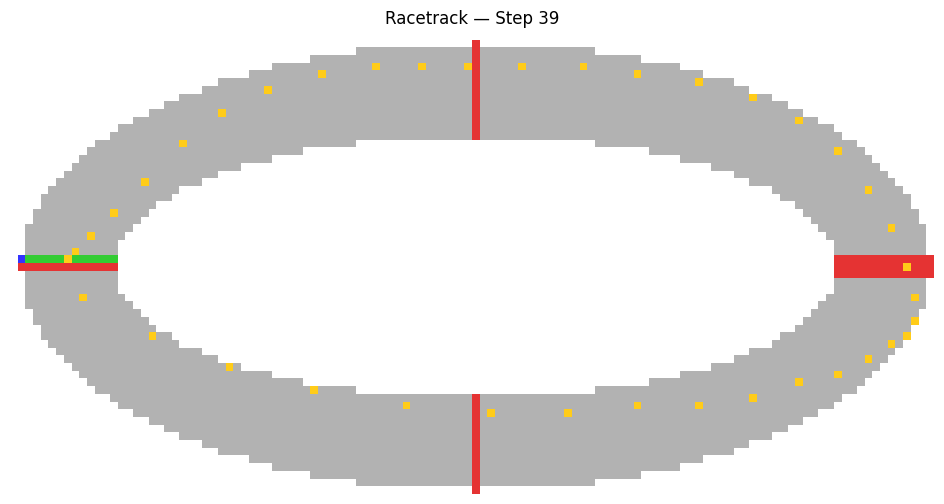

In [ ]:
display.Image(data="pictures/Racetrack_optimal_path_example.png", width=600, height=300)

*Example of a racer's optimal racing line across the oval track.*

***Environment Code***

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from math import dist
from skimage.draw import line  # for Bresenham line algorithm

# Constants for cell types
EMPTY = 0
TRACK = 1
START = 2
CHECKPOINT = 3
WALL = 4
FINISH = 5 # don't actually need for this, we define in the environment in such a way the last checkpoint gives a reward adequate of a finish

# Action space
up_left = (-1, -1)
up = (-1, 0)
up_right = (-1, 1)
left = (0, -1)
maintain = (0, 0)
right = (0, 1)
down_left = (1, -1)
down = (1, 0)
down_right = (1, 1)

action_space = [
    up_left, up, up_right,
    left, maintain, right,
    down_left, down, down_right
]
n_actions = len(action_space)

# Agent/Car class
class RacetrackCar:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.vx = 0
        self.vy = 0

    def apply_action(self, ax, ay):
        self.vx += ax
        self.vy += ay
        self.x += self.vx
        self.y += self.vy
        return (self.x, self.y, self.vx, self.vy)

    def reset(self, x, y):
        self.x, self.y = x, y
        self.vx = self.vy = 0
        return (self.x, self.y, self.vx, self.vy)

# Oval track generation
def generate_oval_track(height=60, width=120, thickness=12):
    grid = np.zeros((height, width), dtype=int)
    cy, cx = height // 2, width // 2
    ry_outer, rx_outer = height // 2 - 1, width // 2 - 1
    ry_inner, rx_inner = ry_outer - thickness, rx_outer - thickness

    for y in range(height):
        for x in range(width):
            dy = (y - cy) / ry_outer
            dx = (x - cx) / rx_outer
            d_outer = dx**2 + dy**2

            dy = (y - cy) / ry_inner
            dx = (x - cx) / rx_inner
            d_inner = dx**2 + dy**2

            if d_outer <= 1.0 and d_inner >= 1.0:
                grid[y, x] = TRACK

    # Start line on left side
    grid[cy-1:cy+2][0][1:thickness+2] = START

    # Checkpoints (center vertical top, center vertical bottom, right edge horizontal, left edge horizontal), note: these are not ordered checkpoints yet
    grid[:, cx][1:thickness+2] = CHECKPOINT
    grid[cy-1:cy+2, -thickness-1:] = CHECKPOINT
    grid[:, cx][-thickness-1:] = CHECKPOINT
    grid[cy-1:cy+2][1][1:thickness+2] = CHECKPOINT

    return grid

# Get Bresenham path between two points
def get_path_cells(x0, y0, x1, y1):
    rr, cc = line(y0, x0, y1, x1)  # Note: (row, col)
    return list(zip(cc, rr))       # Return as (x, y)

# Main Environment Class
class RacetrackEnv:
    def __init__(self, map_name='oval'):
        if map_name == 'oval':
            self.map = generate_oval_track()
        else:
            raise NotImplementedError("Only procedural oval supported for now.")

        # Positions
        self.start_positions = [(x, y) for y, x in zip(*np.where(self.map == START))]
        self.checkpoint_positions = set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)))
        self.track_positions = set((x, y) for y, x in zip(*np.where(self.map == TRACK)))

        self.walls = set()

        # Ordered checkpoint zones (manually grouped by x,y regions)
        cx, cy = self.map.shape[1] // 2, self.map.shape[0] // 2
        self.checkpoints = [
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if x == cx and y < cy),  # vertical top center
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if y == cy and x > cx),  # right horizontal center
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if x == cx and y > cy),  # vertical bottom center
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if y == cy and x < cx),  # left horizontal center
        ]
        self.total_checkpoints = len(self.checkpoints)

        self.checkpoint_idx = 0
        self.car = None
        self.done = False
        self.reward = 0
        self.step_count = 0
        self.trail = []

    def reset(self):
        start = self.start_positions[len(self.start_positions) // 2]
        self.car = RacetrackCar(*start)
        self.done = False
        self.reward = 0
        self.step_count = 0
        self.checkpoint_idx = 0
        self.trail = [start]
        return self.get_state()

    def get_state(self):
        return (self.car.x, self.car.y, self.car.vx, self.car.vy)

    def is_on_track(self, x, y):
        return (x, y) in self.track_positions or (x, y) in self.checkpoint_positions or (x, y) in self.start_positions

    def step(self, action):
        self.step_count += 1
        ax, ay = action
        old_x, old_y = self.car.x, self.car.y
        x, y, vx, vy = self.car.apply_action(ax, ay)
        self.trail.append((x, y))

        self.reward = 0

        # All the rewards here have been optimized through trial and error
        # Progress reward for moving towards next target checkpoint
        checkpoint = list(self.checkpoints[min(self.checkpoint_idx, self.total_checkpoints - 1)])[0]
        prev_dist = np.linalg.norm(np.array([old_x, old_y]) - np.array(checkpoint))
        new_dist = np.linalg.norm(np.array([x, y]) - np.array(checkpoint))
        self.reward = (prev_dist - new_dist) * 1.0
        

        # Step penalty to encourage efficiency
        self.reward -= 5.0

        # Crash check and penalty 
        if not (0 <= x < self.map.shape[1] and 0 <= y < self.map.shape[0]) or not self.is_on_track(x, y):
            self.done = True
            self.reward = -100
            return self.get_state(), self.reward, self.done, {}

        # Check path cells
        path_cells = get_path_cells(old_x, old_y, x, y)

        # Reached correct checkpoint
        if self.checkpoint_idx < self.total_checkpoints:
            target_zone = self.checkpoints[self.checkpoint_idx]
            if any(cell in target_zone for cell in path_cells):
                self.checkpoint_idx += 1
                self.reward = 20

                # big reward if agent reaches last checkpoint/finish line
                if self.checkpoint_idx >= self.total_checkpoints:
                    self.done = True
                    self.reward += 100

        # We have to account for exploiting checkpoints:
        # 1. Reached previous checkpoint (backward)
        elif any(cell in zone for zone in self.checkpoints[:self.checkpoint_idx] for cell in path_cells):
            self.reward -= 20

        # 2. Skipped ahead
        elif any(cell in zone for zone in self.checkpoints[self.checkpoint_idx + 1:] for cell in path_cells):
            self.reward -= 50

        return self.get_state(), self.reward, self.done, {}

    # this allows us to visualise the grid with a trail of past actions (yellow) up to the current step (blue)
    def render(self):
        img = np.zeros((*self.map.shape, 3))
        color_map = {
            EMPTY: (1, 1, 1),
            TRACK: (0.7, 0.7, 0.7),
            START: (0.2, 0.8, 0.2),
            CHECKPOINT: (0.9, 0.2, 0.2),
        }

        # Base map
        for y in range(self.map.shape[0]):
            for x in range(self.map.shape[1]):
                img[y, x] = color_map.get(self.map[y, x], (0, 0, 0))

        # Highlight active checkpoint
        for i, zone in enumerate(self.checkpoints):
            for x, y in zone:
                if i == self.checkpoint_idx:
                    img[y, x] = (1.0, 0.5, 0.0)  # Orange, if it is the next checkpoint to be targeted
                else:
                    img[y, x] = (0.9, 0.2, 0.2)  # Red, otherwise

        # Draw trail (yellow)
        for (x, y) in self.trail:
            if 0 <= x < self.map.shape[1] and 0 <= y < self.map.shape[0]:
                img[y, x] = (1.0, 0.8, 0.1)

        # Draw car (blue)
        if self.car:
            x, y = self.car.x, self.car.y
            if 0 <= x < self.map.shape[1] and 0 <= y < self.map.shape[0]:
                img[y, x] = (0.2, 0.2, 1.0)

        plt.figure(figsize=(12, 6))
        plt.imshow(img, origin='upper')
        plt.title(f"Racetrack — Step {self.step_count}")
        plt.axis('off')
        plt.show()


##### **2.1.2: Overview of Tabular RL Algorithms**

Given that the discrete racetrack environment is fully observable and follows the Markov property, it can be modelled as a Markov Decision Process (MDP). As such, reinforcement learning methods that operate in the tabular setting, where each discrete state-action pair is explicitly represented, are appropriate for learning optimal control policies.

***Focus: Temporal Difference Methods***

In this project, we employ a selection of tabular temporal-difference (TD) learning algorithms, including SARSA(0), SARSA(λ), Q-learning, and Double Q-learning. These methods iteratively estimate the optimal action-value function based on sampled transitions, enabling the agent to improve its policy without requiring prior knowledge of the environment's dynamics.

The mathematical formulations and update rules for each algorithm are provided in **Appendix A** for completeness. In the main body, we focus on their conceptual roles:
- *SARSA(0)*: An on-policy TD method meaning it updates action-values based on the agent’s actual behaviour. For brevity, going forward we refer to this as simply SARSA.
- *SARSA(λ)*: An extension of SARSA(0) using eligibility traces to propagate rewards backward through visited states.
- *Q-learning*: An off-policy TD method mearning it updates action-values based on greedy action selection, regardless of behaviour policy.
- *Double Q-learning*: A variant of Q-learning designed to mitigate overestimation bias through independent value estimates.

Each of these algorithms is trained using an **ε-greedy exploration strategy**, for its simplicity, computational efficiency, and adaptability (over e.g., upper confidence bound), where the agent selects random exploratory actions with a probability ε, ensuring sufficient exploration of policies/actions during training whilst balancing their exploitation.

***Why not Dynamic Programming and Monte Carlo Methods?***

Although *dynamic programming (DP)* techniques such as value iteration and policy iteration are theoretically applicable to MDPs with known transition models, they are not practical in this setting. The environment’s discrete state space, defined by position and velocity, is very large for purposes of practicality, making exhaustive state-space updates computationally infeasible. Furthermore, while the transition dynamics are deterministic and fully defined, **DP methods typically assume manageable state-action spaces for direct value backups, which is not the case here**.

*Monte Carlo (MC)* methods, which learn value functions based on complete returns sampled from full episodes, could potentially be applied to this environment. MC methods have advantages in MDPs where environment models are unknown or where full episodes are naturally terminated, as is the case here. However, their **reliance on waiting until the end of each episode to update action-values could lead to significantly slower learning**, especially in an environment where episodes may last many steps and where the state space is large. Consequently, Monte Carlo methods are not the immediate focus of this project, and we shall see its shortcomings when analysing a SARSA(λ) agent with high λ (see **Appendix A** for their relationship).


##### **2.1.2: Basic Implemenation of TD Learning Algorithms**

Training is conducted across multiple independent runs, each comprising thousands of episodes in order to ensure clear convergence or depict slow learning. Rewards are averaged over runs to evaluate the learning stability and efficiency of each algorithm. The **objective over the next few subsections is to determine the RL learning algorithm which generates the most greatest, consistent converged reward**, and thus most consistent optimal racing path.

As for the main parameter set $(\alpha, \gamma, \epsilon)$, we assign standard estimates to the learning rate, discount rate, and $\epsilon$-greedy exploration rate, such that $(\alpha, \gamma, \epsilon) = (0.1, 0.99, 0.1)$. As we proceed through this section, we shall conduct optimization on this parameter set via decaying strategies and grid searches, in order to train the best possible TD learning agent to navigate our custom environment. This will therefore provide us with our best approximation to the optimal racing line.

Importantly, we set episode length to "500", in order to ensure slower methods, such as double Q-learning (which needs to update two tables) and SARSA(λ) (with high λ), explore enough steps throughout each episode to learn optimal actions at each state. Furthermore, our reasoning for initially testing with a high λ for SARSA(λ) is to twofold: to highlight the slow convergence/learning of methods more akin to MC methods, and to distinguish between SARSA(0) (SARSA) and SARSA(λ) more noticeably within our subsequent analysis.

Notably, each algorithm includes a mechanism for recording the best-performing Q-table over the course of training. This is accomplished by evaluating the average reward over the final N episodes (e.g., the last 50) for each of the R independent training runs, and selecting the best Q-table from the run with the highest average performance. The purpose of this selection process is to ultimately, **in later subsections, visualize the most optimized TD-learning agent navigating the custom racetrack environment**, thereby reinforcing the core objective of the project: learning optimal racing trajectories through reinforcement learning.


In [ ]:
#################
### Libraries ###
#################

# importing necessary Python libraries
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import copy

#####################################
### ε-greedy exploration strategy ###
#####################################

# standard e-greedy selection
def epsilon_greedy(Q, state, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, len(action_space) - 1)
    else:
        q_vals = [Q[(state, a)] for a in range(len(action_space))]
        max_q = max(q_vals)
        best_actions = [a for a, q in enumerate(q_vals) if q == max_q]
        return random.choice(best_actions)

def epsilon_greedy_double(Q1, Q2, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(action_space))
    else:
        # Use the sum of Q1 and Q2 for more balanced action selection
        values = np.array([Q1[(state, a)] + Q2[(state, a)] for a in range(len(action_space))])
        return np.argmax(values)

######################################
### Communication with environment ###
######################################

def discretize_state(state):
    x, y, vx, vy = state
    return (x, y, vx, vy)


#############################
### Tabular RL Algorithms ###
#############################

# 1. one-step SARSA Algorithm
def train_sarsa_average(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1):
    rewards_per_episode = np.zeros(episodes)
    Q_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run+1}/{runs}")
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                # one-step SARSA update (on-policy)
                Q[(state, a_idx)] += alpha * (
                    reward + gamma * Q[(next_state, next_a_idx)] - Q[(state, a_idx)]
                )

                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q_final_list.append(copy.deepcopy(Q))  # Save final Q-table of this run

        # We use the average reward of last N episodes to determine the best overall Q-table out of R runs
        N = 50
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    # Select Q-table from best-performing run as the argument of the max final N episodes' averages
    best_idx = np.argmax(final_rewards)
    best_Q = Q_final_list[best_idx]

    return best_Q, rewards_per_episode


# 2. one-step Q-learning Algorithm
def train_q_learning_average(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1):
    rewards_per_episode = np.zeros(episodes)
    Q_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run+1}/{runs}")
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)

                # Q-Learning update (off-policy)
                max_next_Q = max([Q[(next_state, a)] for a in range(len(action_space))])
                Q[(state, a_idx)] += alpha * (
                    reward + gamma * max_next_Q - Q[(state, a_idx)]
                )

                # Choose next action using epsilon-greedy
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q_final_list.append(copy.deepcopy(Q))  # Save final Q-table of this run

        # We use the average reward of last N episodes to determine the best Q-table
        N = 50
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    # Select the best-performing Q-table
    best_idx = np.argmax(final_rewards)
    best_Q = Q_final_list[best_idx]

    return best_Q, rewards_per_episode


# 3. one-step Double Q-learning Algorithm
def train_double_q_learning_average(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1):
    rewards_per_episode = np.zeros(episodes)
    Q1_final_list = []
    Q2_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run+1}/{runs}")
        Q1 = defaultdict(float)
        Q2 = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy_double(Q1, Q2, state, epsilon)

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)

                # Randomly decide which Q-table to update
                if random.random() < 0.5:
                    # Update Q1 using Q2 to select action
                    best_next_action = np.argmax([Q1[(next_state, a)] for a in range(len(action_space))])
                    Q1[(state, a_idx)] += alpha * (
                        reward + gamma * Q2[(next_state, best_next_action)] - Q1[(state, a_idx)]
                    )
                else:
                    # Update Q2 using Q1 to select action
                    best_next_action = np.argmax([Q2[(next_state, a)] for a in range(len(action_space))])
                    Q2[(state, a_idx)] += alpha * (
                        reward + gamma * Q1[(next_state, best_next_action)] - Q2[(state, a_idx)]
                    )

                # Choose next action using epsilon-greedy
                next_a_idx = epsilon_greedy_double(Q1, Q2, next_state, epsilon)

                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q1_final_list.append(copy.deepcopy(Q1))
        Q2_final_list.append(copy.deepcopy(Q2))

        N = 50
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    # Pick best run
    best_idx = np.argmax(final_rewards)
    best_Q1 = Q1_final_list[best_idx]
    best_Q2 = Q2_final_list[best_idx]

    return best_Q1, best_Q2, rewards_per_episode

###########################################################
### Additional plotting and environment comm. functions ###
###########################################################

def plot_avg_rewards(avg_rewards, title="SARSA Learning Curve"):
    plt.figure(figsize=(14, 7))
    plt.plot(avg_rewards, label="SARSA (avg over runs)", color='blue')
    plt.xlabel("Episode")
    plt.ylabel("Average Total Reward")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# this allows for a fresh environment in each run
def make_env():
    return RacetrackEnv('oval')

***Pre-Results Optimisation: SARSA(λ) Optimization with Trace Pruning***

SARSA(λ) extends the one-step SARSA algorithm by incorporating eligibility traces, allowing the agent to assign credit not only to the most recent action, but to a sequence of recently visited state-action pairs. This facilitates more efficient learning in environments where rewards are sparse or delayed (e.g., checkpoints), such as our optimal racing line task.

In the standard implementation of SARSA(λ), the eligibility trace for every previously visited state-action pair is updated at every time step. While theoretically sound, this process introduces significant computational overhead, as we found during testing, particularly in long episodes or environments with large state spaces such as the one we consider. Without constraints, the eligibility trace dictionary can grow rapidly, which leads to slower execution and inefficient memory use.

To address this, we implemented trace pruning: any eligibility trace with a value falling below a small threshold (e.g., 1×10^−4) is removed from the update loop i.e. **irrelevant traces are not considered**. This minor modification preserves the performance benefits of SARSA(λ) while **substantially improving runtime efficiency**. The pruning ensures that only the most relevant recent transitions contribute to learning, which is especially beneficial in episodic tasks with extended trajectories such as the one we consider.

By limiting updates to meaningful traces, this optimization made SARSA(λ) competitive in runtime with the other algorithms evaluated, without sacrificing its learning capacity.

In [ ]:
# 4. SARSA(λ) Algorithm
def train_sarsa_lambda(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.9):
    rewards_per_episode = np.zeros(episodes)
    Q_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            E = defaultdict(float)  # Eligibility traces

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                delta = reward + gamma * Q[(next_state, next_a_idx)] - Q[(state, a_idx)]

                # Replace trace
                E[(state, a_idx)] = 1.0

                # Update all Q values, but also:
                # prune eligibility traces and update only significant ones
                prune_threshold = 1e-4  # anything smaller is discarded essentially

                for key in list(E.keys()):
                    Q[key] += alpha * delta * E[key]
                    E[key] *= gamma * lambda_

                    # Prune trace if it's too small
                    if abs(E[key]) < prune_threshold:
                        del E[key]


                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q_final_list.append(copy.deepcopy(Q))

        N = 50
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    best_idx = np.argmax(final_rewards)
    best_Q = Q_final_list[best_idx]

    return best_Q, rewards_per_episode

***Comparison between TD Learning Algorithms***

To evaluate the performance and learning behaviour of different reinforcement learning (RL) approaches within the racetrack environment, we implemented and trained four aforementioned algorithms: SARSA, Q-learning, Double Q-learning, and SARSA(λ). Each algorithm was trained across 10,000 episodes and averaged over multiple runs to mitigate noise. The plots show average total reward per episode over time, allowing us to analyze convergence, variance, and relative performance.

In [ ]:
def compare_algorithms(env_factory, episodes=1000, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.9):
    # Run SARSA
    print("\nTraining SARSA...")
    _, rewards_sarsa = train_sarsa_average(env_factory, episodes, runs, alpha, gamma, epsilon)

    # Run Q-Learning
    print("\nTraining Q-Learning...")
    _, rewards_qlearning = train_q_learning_average(env_factory, episodes, runs, alpha, gamma, epsilon)

    # Run Double Q-Learning
    print("\nTraining Double Q-Learning...")
    _, _, rewards_doubleq = train_double_q_learning_average(env_factory, episodes, runs, alpha, gamma, epsilon)

    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda = train_sarsa_lambda(env_factory, episodes, runs, alpha, gamma, epsilon, lambda_)

    # Plot all results
    plt.figure(figsize=(14, 7))
    plt.plot(rewards_sarsa, label="SARSA", color='blue', alpha=0.75)
    plt.plot(rewards_qlearning, label="Q-Learning", color='green', alpha=0.75)
    plt.plot(rewards_doubleq, label="Double Q-Learning", color='red', alpha=0.75)
    plt.plot(rewards_sarsalambda, label=f"SARSA(λ={lambda_})", color='purple', alpha=0.75)

    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title("RL Algorithm Comparison (Avg over runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def compare_q_learning_algorithms(env_factory, episodes=1000, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1):

    # Run Q-Learning
    print("\nTraining Q-Learning...")
    _, rewards_qlearning = train_q_learning_average(env_factory, episodes, runs, alpha, gamma, epsilon)

    # Run Double Q-Learning
    print("\nTraining Double Q-Learning...")
    _, _, rewards_doubleq = train_double_q_learning_average(env_factory, episodes, runs, alpha, gamma, epsilon)


    # Plot all results
    plt.figure(figsize=(14, 7))
    plt.plot(rewards_qlearning, label="Q-Learning", color='green', alpha=0.75)
    plt.plot(rewards_doubleq, label="Double Q-Learning", color='red', alpha=0.75)
    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title("Q-learning vs Double Q-learning Comparison (Avg over runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def compare_q_and_sarsa_algorithms(env_factory, episodes=1000, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1):
    # Run SARSA
    print("\nTraining SARSA...")
    _, rewards_sarsa = train_sarsa_average(env_factory, episodes, runs, alpha, gamma, epsilon)

    # Run Q-Learning
    print("\nTraining Q-Learning...")
    _, rewards_qlearning = train_q_learning_average(env_factory, episodes, runs, alpha, gamma, epsilon)

    # Plot all results
    plt.figure(figsize=(14, 7))
    plt.plot(rewards_sarsa, label="SARSA", color='blue', alpha=0.75)
    plt.plot(rewards_qlearning, label="Q-Learning", color='green', alpha=0.75)
    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title("Q-learning vs SARSA Comparison (Avg over runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training SARSA...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training Q-Learning...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training Double Q-Learning...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training SARSA(λ)...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


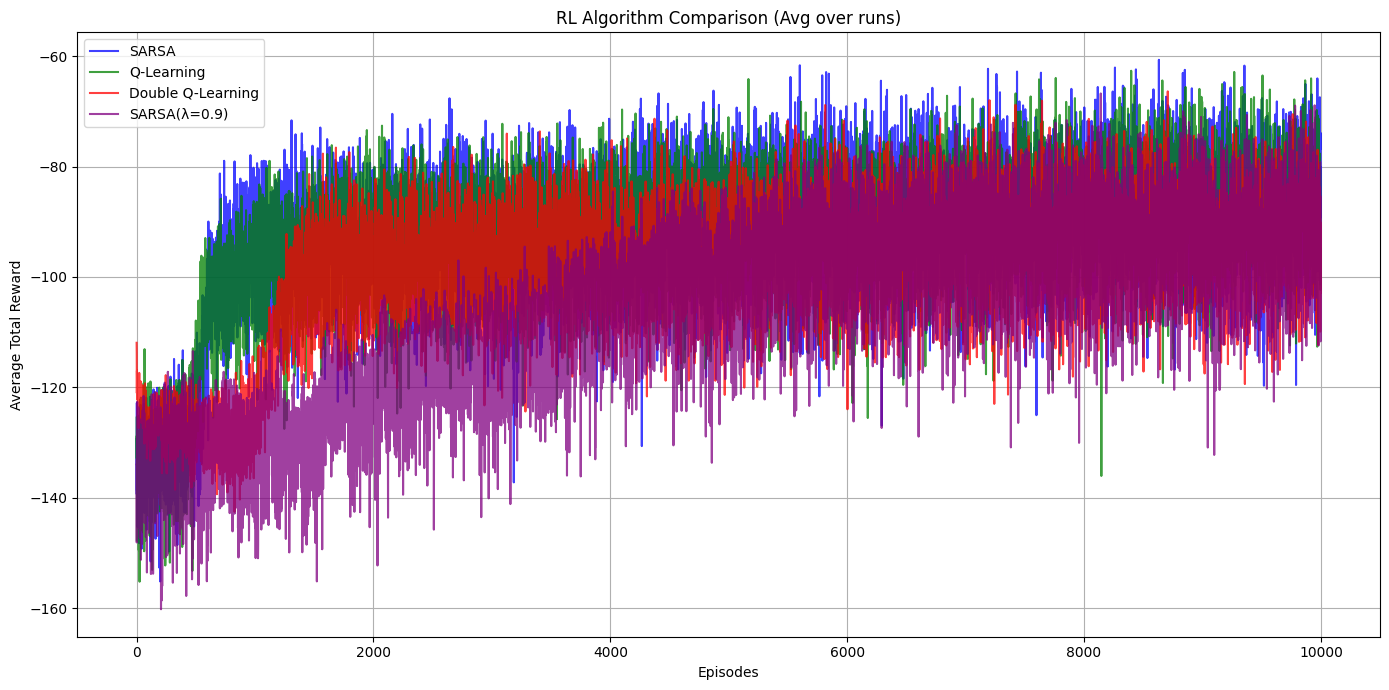

In [ ]:
compare_algorithms(make_env, episodes=10000, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.9)

From a high-level comparison of all four algorithms, one notable distinction emerges in the learning behaviour of SARSA(λ). Unlike the others, which tend to plateau or stagnate after around episode 2000, SARSA(λ) demonstrates a more consistent and steady rise in average reward until approximately episode 8000. Although its early performance is comparatively lower, it gradually catches up and converges to a similar level of average reward as the other methods. This slow but stable improvement is characteristic of SARSA(λ)’s use of eligibility traces, which allow it to propagate value updates across longer state-action chains. These traces facilitate learning from temporally distant rewards, potentially enabling the agent to discover longer-term strategies that improve overall performance. However, despite the more sustained upward trend, SARSA(λ) also does not ultimately surpass the others in terms of peak performance, instead converging to a comparable reward plateau.



Training Q-Learning...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training Double Q-Learning...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


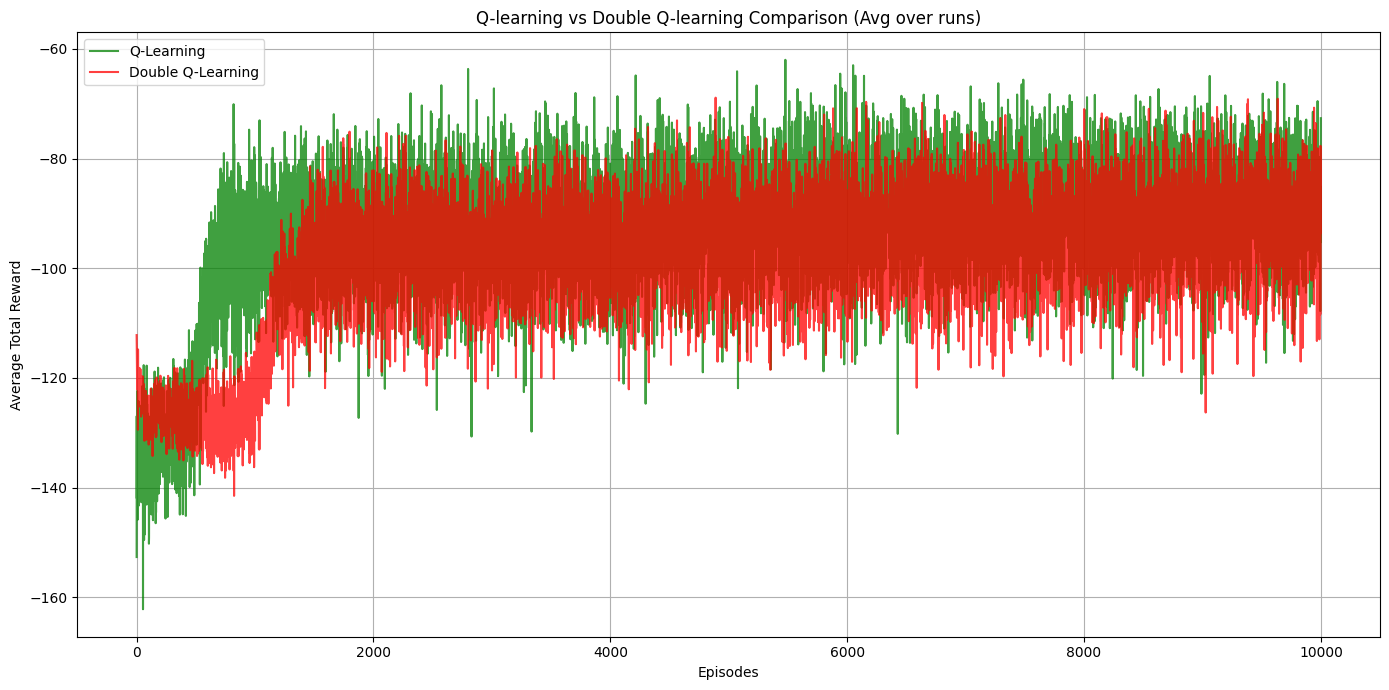

In [ ]:
compare_q_learning_algorithms(make_env, episodes=10000, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1)

Looking more closely at the comparison between Q-learning and Double Q-learning, we observe that Q-learning experiences a rapid initial increase in average reward, quickly rising in performance during the first 500–1000 episodes. In contrast, Double Q-learning initially dips in reward and takes longer to begin its upward trajectory. Only after approximately 1000 episodes does it begin to improve, ultimately stabilizing slightly below Q-learning. This lag can be attributed to the more conservative nature of Double Q-learning updates, which decouple action selection and value evaluation to reduce overestimation bias. However, this also delays early learning. Over time, Double Q-learning manages to perform stably, but there is little evidence from the plotted data that it consistently outperforms or exhibits significantly lower variance than standard Q-learning in this environment.


Training SARSA...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training Q-Learning...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


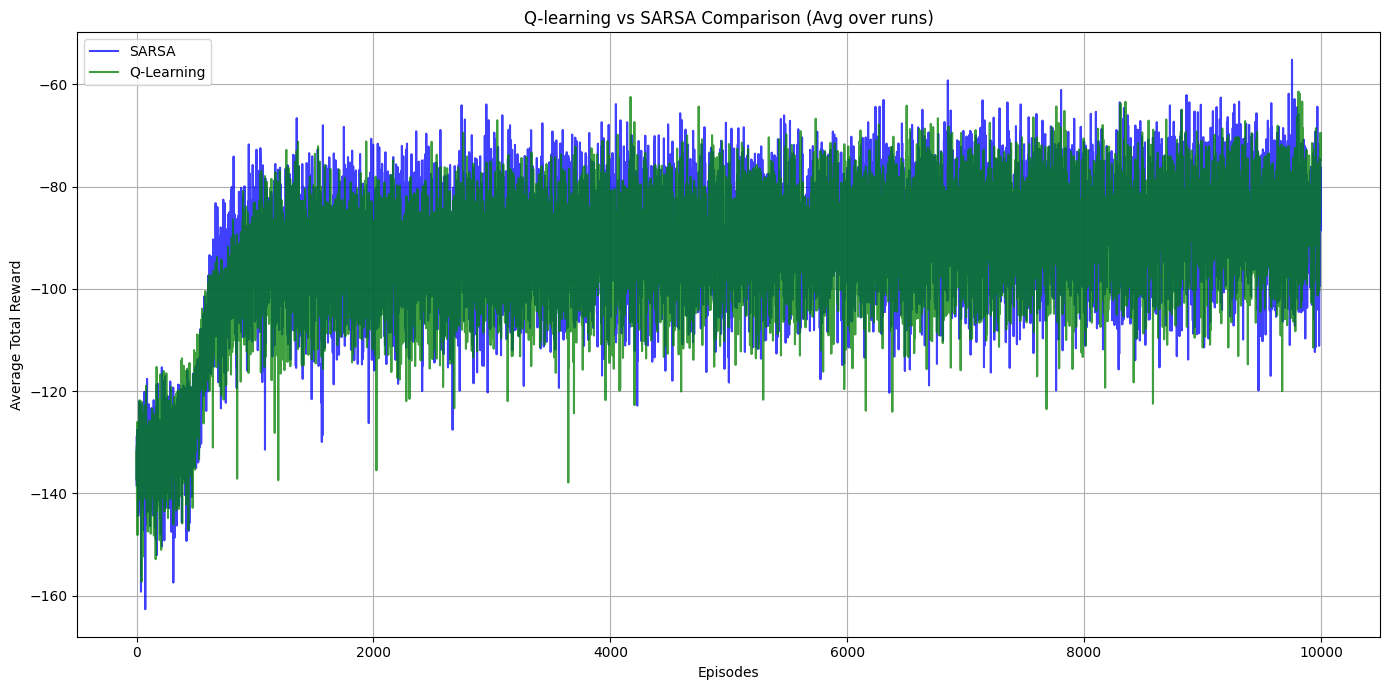

In [ ]:
compare_q_and_sarsa_algorithms(make_env, episodes=10000, runs=10, alpha=0.1, gamma=0.99, epsilon=0.1)

In a separate comparison between Q-learning and SARSA, both algorithms initially track a similar upward path. However, after around episode 500, SARSA appears to edge ahead in average reward. This advantage persists through the remainder of training, with SARSA maintaining a slightly higher reward and fewer sharp drops. This behaviour aligns with the theory that SARSA’s on-policy updates encourage more cautious exploration. In environments where missteps are penalized harshly, such as crashing off the track, this caution can yield safer and more robust learning outcomes. Q-learning, by contrast, is more optimistic in its policy updates, sometimes overvaluing risky state-action pairs that lead to inconsistent performance.

Finally, it is important to recognize a shared limitation across all four methods. Despite variations in learning rates and mechanisms, none of the algorithms converge fully to the optimal policy within 10,000 episodes. Evidence for this can be seen in persistent reward spikes, fluctuations, and the lack of continued upward progress beyond the mid-training point - around episode 2000 for SARSA, Q-learning, and Double Q-learning, and around episode 8000 for SARSA(λ). These plateaus suggest that agents may often settle into suboptimal behaviours that are reinforced inconsistently, possibly due to the sparsity of large rewards and the sharp penalties associated with failure.

***Future Directions***

A primary hypothesis for this slow convergence is insufficient or **poorly guided exploration**. The algorithms may be failing to sufficiently explore promising but distant regions of the state space due to fixed exploration parameters or suboptimal early trajectories. This limitation is particularly impactful in environments like the racetrack, where **successful behaviour involves long chains of coordinated actions** with limited immediate feedback. While some exploration is necessary to escape local optima, unchecked exploration in later episodes can introduce high variance and undermine learning stability.

To address this, one promising avenue involves refining the exploration strategy itself. In particular, a **decaying epsilon-greedy policy**, where the agent gradually shifts from exploration to exploitation over time, may help the agent stabilize its learning as it gains confidence in its Q-values. By encouraging wide exploration early on and reducing randomness as policies mature, decaying epsilon could offer a balance that supports both discovery and convergence. The next subsection will investigate this strategy in more detail and evaluate its impact on learning efficiency and stability across the different algorithms.



##### **2.1.3: Optimisation of TD Learning Algorithms**

Building on the previous findings, this section investigates a key optimisation aimed at improving the convergence of TD learning algorithms: the **introduction of a decaying ε-greedy exploration strategy**. In contrast to the fixed ε used in earlier experiments, this approach gradually reduces the agent’s exploration rate over time. The motivation is to encourage broad exploration in early episodes, when the agent has little knowledge, while promoting more stable, exploitative behaviour as learning progresses. This global change is applied uniformly across all algorithms to assess its impact on learning efficiency and long-term performance.

The specific form of decaying epsilon we consider follows geometric decay, until it hits the lower bound:

$$
\epsilon_t = \max \, ({\epsilon_{min}, \, \epsilon_{start} \, (\text{decay rate})^t}),
$$

where $$0<\text{decay rate}<1.$$ 

Our choices of upper bound (start) and lower bound (min) for the decaying epsilon strategy are motivatived by initially having an exploration phase akin to basic implementation, **moving toward a minimum bound much smaller** (1% of the initial exploration rate), so as to lock-in into the exploitative strategies over time, or in this case, over episodes. Furthermore, we choose a decay rate very close to 1, so as to smooth the rate of decay over the large number of episodes we consider.

In [309]:
#############################################
### Tabular RL Algorithms with decaying ε ###
#############################################

# specifying upper and lower bounds for epsilon + decay rate
epsilon_start = 0.1
epsilon_min = 0.001
decay_rate = 0.995

# 1. one-step SARSA Algorithm
def train_sarsa_average(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99):
    rewards_per_episode = np.zeros(episodes)
    Q_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run+1}/{runs}")
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                # one-step SARSA update
                Q[(state, a_idx)] += alpha * (
                    reward + gamma * Q[(next_state, next_a_idx)] - Q[(state, a_idx)]
                )

                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q_final_list.append(copy.deepcopy(Q))  # Save final Q-table of this run

        # We use the average reward of last N episodes to determine the best overall Q-table out of R runs
        N = 500
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    # Select Q-table from best-performing run as the argument of the max final N episodes' averages
    best_idx = np.argmax(final_rewards)
    best_Q = Q_final_list[best_idx]

    return best_Q, rewards_per_episode


# 2. one-step Q-learning Algorithm
def train_q_learning_average(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99):
    rewards_per_episode = np.zeros(episodes)
    Q_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run+1}/{runs}")
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)

                # Q-Learning update (off-policy)
                max_next_Q = max([Q[(next_state, a)] for a in range(len(action_space))])
                Q[(state, a_idx)] += alpha * (
                    reward + gamma * max_next_Q - Q[(state, a_idx)]
                )

                # Choose next action using epsilon-greedy
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q_final_list.append(copy.deepcopy(Q))  # Save final Q-table of this run

        # We use the average reward of last N episodes to determine the best Q-table
        N = 500
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    # Select the best-performing Q-table
    best_idx = np.argmax(final_rewards)
    best_Q = Q_final_list[best_idx]

    return best_Q, rewards_per_episode


# 3. one-step Double Q-learning Algorithm
def train_double_q_learning_average(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99):
    rewards_per_episode = np.zeros(episodes)
    Q1_final_list = []
    Q2_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run+1}/{runs}")
        Q1 = defaultdict(float)
        Q2 = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy_double(Q1, Q2, state, epsilon)

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)

                # Randomly decide which Q-table to update
                if random.random() < 0.5:
                    # Update Q1 using Q2 to select action
                    best_next_action = np.argmax([Q1[(next_state, a)] for a in range(len(action_space))])
                    Q1[(state, a_idx)] += alpha * (
                        reward + gamma * Q2[(next_state, best_next_action)] - Q1[(state, a_idx)]
                    )
                else:
                    # Update Q2 using Q1 to select action
                    best_next_action = np.argmax([Q2[(next_state, a)] for a in range(len(action_space))])
                    Q2[(state, a_idx)] += alpha * (
                        reward + gamma * Q1[(next_state, best_next_action)] - Q2[(state, a_idx)]
                    )

                # Choose next action using epsilon-greedy
                next_a_idx = epsilon_greedy_double(Q1, Q2, next_state, epsilon)

                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q1_final_list.append(copy.deepcopy(Q1))
        Q2_final_list.append(copy.deepcopy(Q2))

        N = 500
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    # Pick best run
    best_idx = np.argmax(final_rewards)
    best_Q1 = Q1_final_list[best_idx]
    best_Q2 = Q2_final_list[best_idx]

    return best_Q1, best_Q2, rewards_per_episode


# 4. SARSA(λ) Algorithm
def train_sarsa_lambda(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99, lambda_=0.9):
    rewards_per_episode = np.zeros(episodes)
    Q_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            E = defaultdict(float)  # Eligibility traces

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                delta = reward + gamma * Q[(next_state, next_a_idx)] - Q[(state, a_idx)]

                # Replace trace
                E[(state, a_idx)] = 1.0

                # Update all Q values, but also:
                # prune eligibility traces and update only significant ones
                prune_threshold = 1e-4  # anything smaller is discarded essentially

                for key in list(E.keys()):
                    Q[key] += alpha * delta * E[key]
                    E[key] *= gamma * lambda_

                    # Prune trace if it's too small
                    if abs(E[key]) < prune_threshold:
                        del E[key]


                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q_final_list.append(copy.deepcopy(Q))

        N = 1000
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    best_idx = np.argmax(final_rewards)
    best_Q = Q_final_list[best_idx]

    return best_Q, rewards_per_episode

***Comparison between TD Learning Algorithms, with decaying ε***

As a slight change to before, each algorithm was trained across 20,000 episodes instead, as we found improved levels of learning during testing albeit compounded with the slow learning associated with a state space this large. As before, the plots show average total reward per episode over time, allowing us to analyze convergence, variance, and relative performance.

In [ ]:
def compare_algorithms(env_factory, episodes=1000, runs=10, alpha=0.1, gamma=0.99, lambda_=0.9):
    # Run SARSA
    print("\nTraining SARSA...")
    _, rewards_sarsa = train_sarsa_average(env_factory, episodes, runs, alpha, gamma)

    # Run Q-Learning
    print("\nTraining Q-Learning...")
    _, rewards_qlearning = train_q_learning_average(env_factory, episodes, runs, alpha, gamma)

    # Run Double Q-Learning
    print("\nTraining Double Q-Learning...")
    _, _, rewards_doubleq = train_double_q_learning_average(env_factory, episodes, runs, alpha, gamma)

    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda = train_sarsa_lambda(env_factory, episodes, runs, alpha, gamma, lambda_)

    # Plot all results
    plt.figure(figsize=(14, 7))
    plt.plot(rewards_sarsa, label="SARSA", color='blue', alpha=0.75)
    plt.plot(rewards_qlearning, label="Q-Learning", color='green', alpha=0.75)
    plt.plot(rewards_doubleq, label="Double Q-Learning", color='red', alpha=0.75)
    plt.plot(rewards_sarsalambda, label=f"SARSA(λ={lambda_})", color='purple', alpha=0.75)

    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title("RL Algorithm Comparison, with decaying ε (Avg over runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training SARSA...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training Q-Learning...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training Double Q-Learning...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Training SARSA(λ)...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


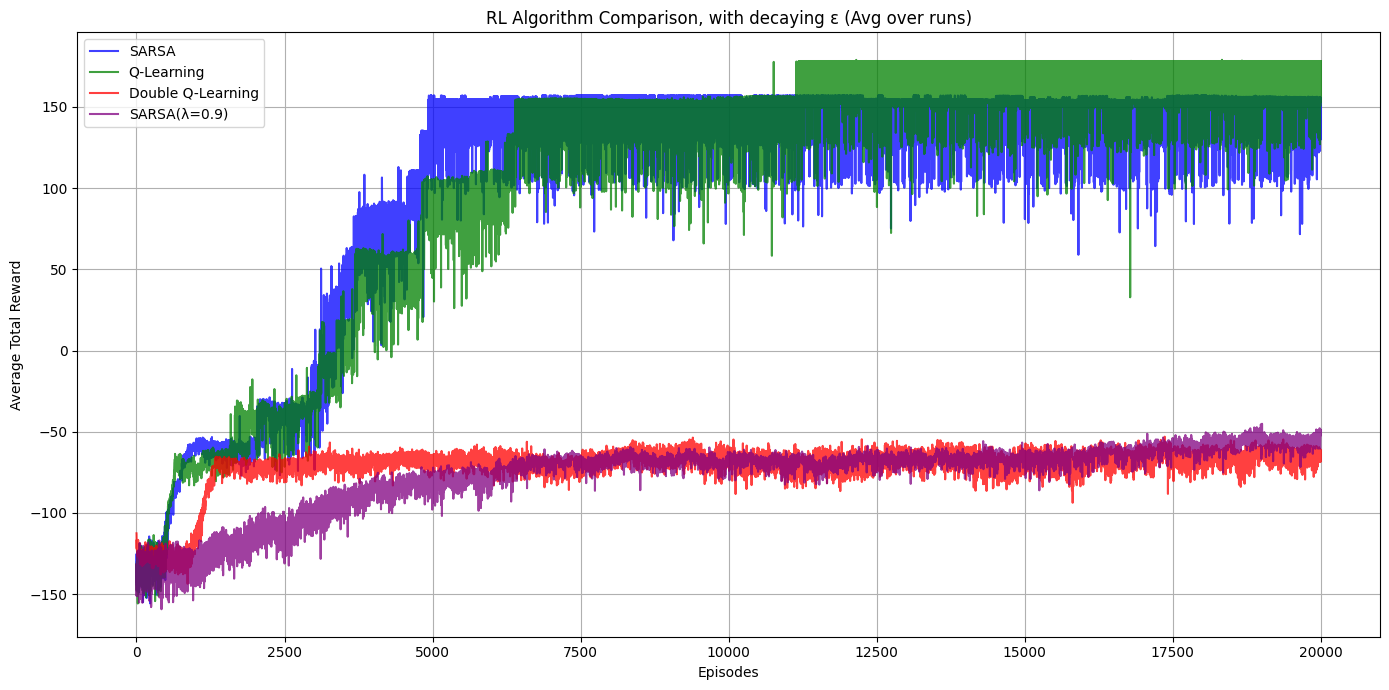

In [ ]:
compare_algorithms(make_env, episodes=20000, runs=10, alpha=0.1, gamma=0.99, lambda_=0.9)

This latest plot, generated under a decaying ε-greedy strategy across 20,000 episodes, reveals the most distinct divergence in performance between the temporal-difference algorithms studied. The standout performer is clearly **Q-learning (green), which not only achieves the highest average reward, but does so to a clear, distinctive margin**. This suggests Q-learning benefits most from the decaying ε schedule, leveraging its off-policy nature to take riskier, higher-return actions during exploration, and locking in the gains as ε shrinks. The rapid increase in performance between episodes 2500 and 6000 indicates efficient identification and reinforcement of optimal action sequences.

**SARSA (blue) follows a similar trajectory**, albeit initially more quickly. It climbs rapidly in performance and eventually reaches its stable level before Q-learning does. While its learning is faster, it eventually caps out at a level below that of Q-learning. Nevertheless, the plot shows that SARSA still benefits greatly from ε decay. Addtionally, as its on-policy updates lead to safer but more deliberate optimization, SARSA's more conservative nature is likely the cause of this lower cap, as it favors actions that have historically produced safer outcomes, potentially missing the more nuanced, aggressive strategies that Q-learning is more likely to discover and exploit.

The key distinction in performance here, however, is not related to crashes or checkpoint misses, but rather more subtle nuances in trajectory efficiency, especially those that reduce the number of steps (and thus, time penalties) per lap. Since the environment provides incremental negative rewards for longer trajectories, Q-learning’s willingness to explore more direct (though initially risky) routes at each state appears to be a winning strategy. This can be seen by how Q-learning experiences sharper reward spikes and drops than SARSA, especially in the latter half of episodes.

On the other end of the spectrum, **Double Q-learning (red) and SARSA(λ=0.9) (purple) perform significantly worse**. Both plateau early and fail to leverage the benefits of the decaying ε strategy. Initially, this underperformance was attributed to slower propagation of value estimates and inefficiencies in long-term credit assignment. However, further experimentation revealed a critical factor: the **severity of the step penalty** in the environment.

***Impact of Step Penalty on Double Q-Learning and High-λ SARSA(λ)***

During testing, when the step penalty was reduced from -5 (used throughout this project) to -2 temporarily, both Double Q-learning and SARSA(λ=0.9) demonstrated marked improvements in learning. However, this improvement came at a cost, as the diminished penalty weakened the incentive to complete the track efficiently, leading to suboptimal behaviour in terms of lap time. It was for this reason the decision was made to **retain the stricter -5 penalty as the step penalty used throughout this project**.

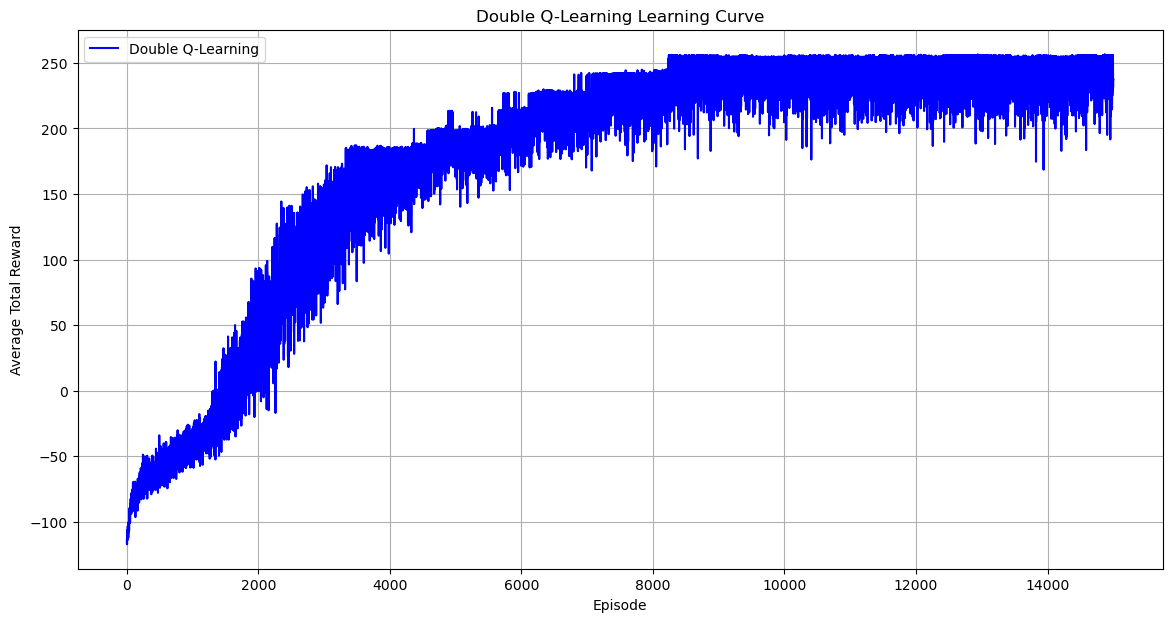

In [ ]:
display.Image(data="pictures/Double_Q_learning_step_penalty__-2.png", width=1000)

*Example of Double Q-learning's total reward performance over 15,000 episodes, averaged over 20 runs, **with step penalty = -2.0**. Note: due to a more generous step penalty, the converged reward is higher than the case with step penalty = -5.0.* 


The poor performance of these two algorithms under a harsher step penalty can be attributed to their core mechanics. Double Q-learning, which alternates updates between two Q-value estimators to reduce overestimation, naturally slows down value propagation. In sparse-reward environments, the addition of frequent negative step rewards makes it difficult for the agent to accumulate sufficient positive reinforcement, particularly when updates are split between Q1 and Q2.

Similarly, SARSA(λ=0.9), with a high λ value, approximates a Monte Carlo-style update, where credit is distributed across entire trajectories. In long episodes with delayed rewards and frequent penalties, the positive signal is easily overwhelmed by early negative feedback, leading to poor gradient direction and reduced motivation to complete the task.

Thus, while both algorithms can benefit from softer step penalties, doing so would contradict the core design of the environment, which is to encourage the agent to minimize its step count. As a result, future optimization efforts focus instead on tuning algorithmic hyperparameters, such as λ itself in SARSA(λ), to improve learning without compromising the environment’s behavioural incentives. To achieve this, we **conduct a λ-grid search to identify a more suitable value that accelerates learning for SARSA(λ)** without sacrificing trace utility. **Once an optimized $\lambda^*$ is selected, SARSA($\lambda^*$) can be re-evaluated against Q-learning for a final benchmark**.

***Investigating the optimal λ for SARSA(λ) with grid searching***

In order implement this grid search, we first discretise the domain of $\lambda \in [0, 1]$ evenly across 11 points, so in other words, $$\lambda_i = \{0, 0.1, \dots, 0.9, 1\} \text{, for} \, \, i = 1, 2, \dots, 11.$$

The objective is to find the value $\lambda^*$ maximising the average total reward over the final 10% of training episodes (e.g., N = 2000 for 20,000 episodes), further averaged across a large number of independent runs (e.g., R = 50) of the SARSA(λ) algorithm described earlier. Note that we also include the case $\lambda=0$, which corresponds to the standard SARSA algorithm.

λ = 0.00 → Final Avg Reward = 156.76
λ = 0.10 → Final Avg Reward = 163.32
λ = 0.20 → Final Avg Reward = 166.82
λ = 0.30 → Final Avg Reward = 169.30
λ = 0.40 → Final Avg Reward = 171.44
λ = 0.50 → Final Avg Reward = 171.66
λ = 0.60 → Final Avg Reward = 162.84
λ = 0.70 → Final Avg Reward = -76.96
λ = 0.80 → Final Avg Reward = -72.71
λ = 0.90 → Final Avg Reward = -54.24
λ = 1.00 → Final Avg Reward = -111.23


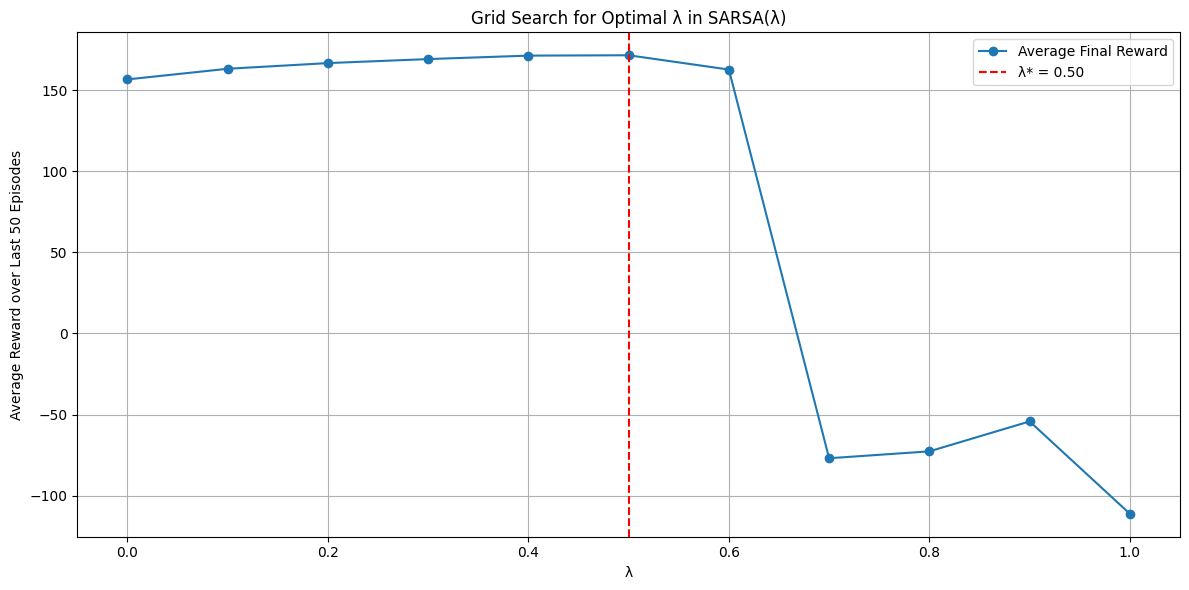

In [ ]:
################################################
### Grid Search on SARSA(λ) Algorithm over λ ###
################################################

# Grid search settings
lambda_values = np.round(np.linspace(0, 1, 11), 2)
episodes = 20000
N = 2000  # last N episodes to average
runs = 50 # number of runs to further average
alpha = 0.1
gamma = 0.99
epsilon_start = 0.1
epsilon_min = 0.001
decay_rate = 0.995

# SARSA(λ) Algorithm
def train_sarsa_lambda_grid(env_factory, episodes, runs, alpha, gamma, lambda_):
    final_rewards = []

    for run in range(runs):
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            E = defaultdict(float)  # Eligibility traces

            done = False
            total_reward = 0
            steps = 0
            max_steps = 100 # to reduce running time

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                delta = reward + gamma * Q[(next_state, next_a_idx)] - Q[(state, a_idx)]

                # Replace trace
                E[(state, a_idx)] = 1.0

                # Update all Q values, but also:
                # prune eligibility traces and update only significant ones
                prune_threshold = 1e-4  # anything smaller is discarded essentially

                for key in list(E.keys()):
                    Q[key] += alpha * delta * E[key]
                    E[key] *= gamma * lambda_

                    # Prune trace if it's too small
                    if abs(E[key]) < prune_threshold:
                        del E[key]


                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)

        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    return np.mean(final_rewards)

# Running the grid search
lambda_scores = []

for lamda in lambda_values:
    avg_reward = train_sarsa_lambda_grid(make_env, episodes, runs, alpha, gamma, lamda)
    lambda_scores.append(avg_reward)
    print(f"λ = {lamda:.2f} → Final Avg Reward = {avg_reward:.2f}")

# Identifying the optimal lambda
best_idx = np.argmax(lambda_scores)
lambda_star = lambda_values[best_idx]
best_score = lambda_scores[best_idx]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(lambda_values, lambda_scores, marker='o', label='Average Final Reward')
plt.axvline(lambda_star, color='red', linestyle='--', label=f'λ* = {lambda_star:.2f}')
plt.title("Grid Search for Optimal λ in SARSA(λ)")
plt.xlabel("λ")
plt.ylabel(f"Average Reward over Last {N} Episodes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

*Note: There is a y-label typo in the above plot - it is the average over the last **2000 episodes** as we consider 20,000 training episodes.*

The results of the grid search for λ in SARSA(λ) highlight a clear sensitivity to this parameter, particularly in the context of sparse reward environments with significant step penalties. As λ increases from 0 to 0.5, there is a consistent improvement in average total reward, indicating that introducing eligibility traces helps the agent learn more effectively by attributing delayed rewards to relevant preceding states. The **best performance is observed at $\lambda^*$ = 0.5**, which strikes an effective balance between the bias of one-step updates and the variance of long-range backups.

Beyond λ = 0.5, however, the performance deteriorates sharply. This drop becomes especially pronounced for λ $\geq$ 0.7, with the worst performance occurring at λ = 1.0, corresponding to the pure Monte Carlo case. These results reinforce the earlier hypothesis that high-λ SARSA(λ) struggles in environments with long episodes and sparse positive rewards. Since the learning signal is distributed over longer trajectories, early states receive disproportionately strong negative updates from accumulated step penalties before any reward is observed, thus often resulting in stagnation or policy collapse.

***Final Benchmark: Q-learning vs. SARSA($\lambda^*$)***

Now that we have determined the optimal $\lambda$ for the SARSA($\lambda$) algorithm as $\lambda^*=0.5$, we make a final benchmark between the best two performing TD learning algorithms: Q-learning and SARSA($\lambda^*=0.5$). In order to make this comparison as apt as possible, we set the number of runs to 20, so as to find a clearer picture of the distinction, if any, between the two algorithms.


In [ ]:
def compare_q_learning_and_sarsa_lambda_algorithms(env_factory, episodes=1000, runs=10, alpha=0.1, gamma=0.99, lambda_=0.9):
    # Run Q-Learning
    print("\nTraining Q-Learning...")
    _, rewards_qlearning = train_q_learning_average(env_factory, episodes, runs, alpha, gamma)

    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda = train_sarsa_lambda(env_factory, episodes, runs, alpha, gamma, lambda_)

    # Plot all results
    plt.figure(figsize=(14, 7))
    plt.plot(rewards_qlearning, label="Q-Learning", color='green', alpha=0.75)
    plt.plot(rewards_sarsalambda, label=f"SARSA(λ={lambda_})", color='purple', alpha=0.75)

    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title("RL Algorithm Comparison, with decaying ε (Avg over runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training Q-Learning...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20

Training SARSA(λ)...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20


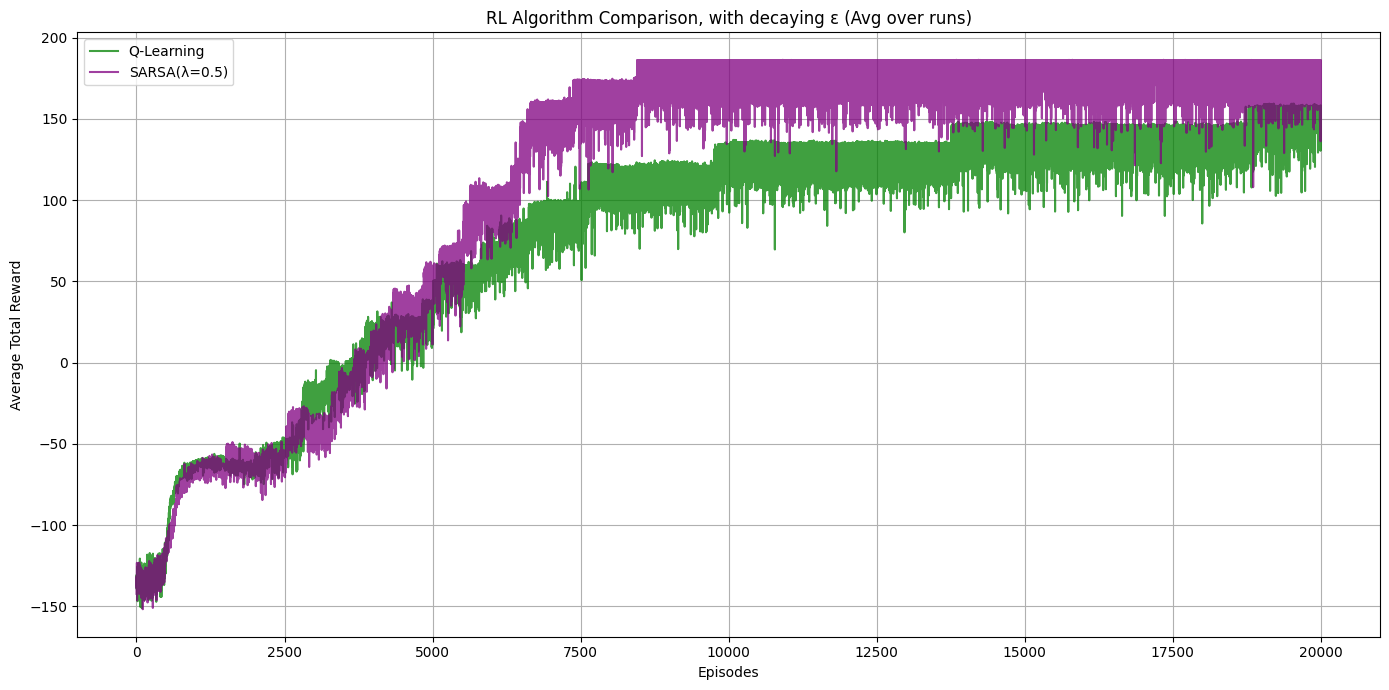

In [ ]:
compare_q_learning_and_sarsa_lambda_algorithms(make_env, episodes=20000, runs=20, alpha=0.1, gamma=0.99, lambda_=0.5)

This plot presents a direct comparison between the best-performing variants of SARSA(λ) and Q-learning under a decaying ε-greedy strategy. From a purely graphical perspective, the improvement of SARSA($\lambda^*=0.5$) over Q-learning is both clear and substantial. Initially, the two algorithms perform similarly, with almost indistinguishable trajectories until approximately episode 5000. However, beyond this point, SARSA($\lambda^*=0.5$) exhibits a notable inflection in performance, rapidly ascending and eventually surpassing Q-learning in both convergence speed and final reward plateau.

By episode 8000, SARSA($\lambda^*=0.5$) has largely stabilized near its maximum average total reward, while Q-learning continues to exhibit slower, less consistent gains throughout the remaining episodes. Crucially, SARSA($\lambda^*=0.5$) not only converges faster but also achieves a higher asymptotic reward than Q-learning over the full training horizon. In terms of variability, neither algorithm appears to have consistently greater volatility; both exhibit moderate fluctuations, though Q-learning maintains a slightly more jagged profile, with more frequent dips. This again supports the earlier observation of SARSA-based methods offering smoother convergence.

From an algorithmic standpoint, these visual trends can be explained by SARSA(λ)'s use of eligibility traces, which provide a more temporally diffuse credit assignment. With $\lambda^*=0.5$, the agent benefits from moderate backward propagation of rewards, allowing it to more efficiently integrate delayed signals; particularly valuable in this environment where sparse checkpoint rewards and a harsh step penalty dominate the learning landscape. The distinction between the two agents' reward curves beyond episode 5000 likely reflects SARSA(λ)'s ability to internalize nuanced trajectory optimizations (e.g., velocity adjustments or smoother turns) that reduce lap time and accumulate less cumulative penalty. These subtleties compound across episodes, leading to the observed long-term advantage.

Thus, **SARSA($\lambda^*=0.5$) emerges as the most superior TD learning strategy for this custom discrete racing environment**, exhibiting not only faster convergence and higher reward ceilings, but also improved policy refinement, likely attributable to its enhanced capacity for propagating credit across temporally extended action sequences.

***Optimising the SARSA($\lambda^*$) TD Learning Algorithm parameter set $(\alpha, \gamma)$ with grid searching***

In order implement this grid search, in a similar fashion to what we did previously with $\lambda$, we first discretise the domains of $\alpha \in [0.01, 1]$ and $\gamma \in [0.01, 0.99]$ evenly across 11 points, so in other words, $$\alpha_i = \{0.01, 0.11, \dots, 0.90, 1.00\}, \gamma_i = \{0.01, 0.11, \dots, 0.89, 0.99\} \text{, for} \, \, i = 1, 2, \dots, 11.$$

Like before, but slightly differently, the objective is to find the values $(\alpha^*, \gamma^*)$ maximising the average total reward over the final 20% of training episodes (e.g., N = 1000 for 5,000 episodes), further averaged across a number of independent runs (e.g., R = 10) of the SARSA($\lambda^*=0.5$) algorithm. However, it should be noted that this grid search uses fewer training episodes and independent runs compared to the previous search over $\lambda$, since the **computational complexity increases from $\mathcal{O}(n)$ to $\mathcal{O}(n^2)$**, where $n$ is the number of discretized values for each distinct parameter (e.g., 11).

Furthermore, it should be noted that the **goal of this optimisation is to improve efficiency and convergence time** to the optimal average total reward, as the current SARSA($\lambda^*=0.5$) algorithm we have trained, with parameters $(\alpha, \gamma) = (0.1, 0.99)$, already reaches this level at some point over 20,000 episodes of training. This further motivates the lower number of training episodes used for this grid search.

testing (alpha, gamma): (0.01, 0.01)
testing (alpha, gamma): (0.01, 0.108)
testing (alpha, gamma): (0.01, 0.20600000000000002)
testing (alpha, gamma): (0.01, 0.30400000000000005)
testing (alpha, gamma): (0.01, 0.402)
testing (alpha, gamma): (0.01, 0.5)
testing (alpha, gamma): (0.01, 0.5980000000000001)
testing (alpha, gamma): (0.01, 0.6960000000000001)
testing (alpha, gamma): (0.01, 0.794)
testing (alpha, gamma): (0.01, 0.892)
testing (alpha, gamma): (0.01, 0.99)
testing (alpha, gamma): (0.109, 0.01)
testing (alpha, gamma): (0.109, 0.108)
testing (alpha, gamma): (0.109, 0.20600000000000002)
testing (alpha, gamma): (0.109, 0.30400000000000005)
testing (alpha, gamma): (0.109, 0.402)
testing (alpha, gamma): (0.109, 0.5)
testing (alpha, gamma): (0.109, 0.5980000000000001)
testing (alpha, gamma): (0.109, 0.6960000000000001)
testing (alpha, gamma): (0.109, 0.794)
testing (alpha, gamma): (0.109, 0.892)
testing (alpha, gamma): (0.109, 0.99)
testing (alpha, gamma): (0.20800000000000002, 0.01)
t

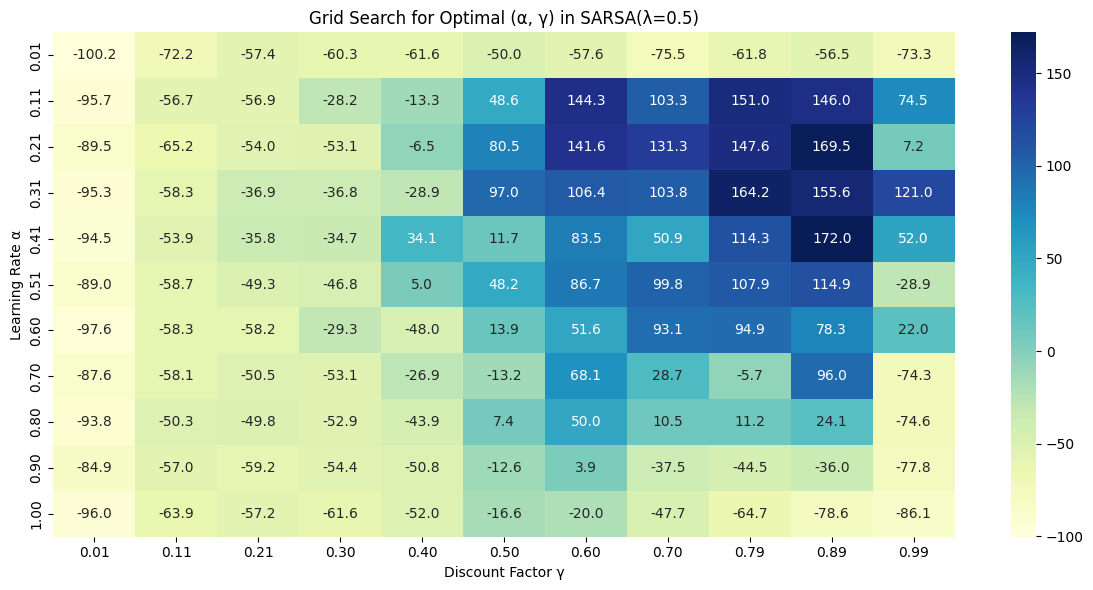

In [286]:
#####################################################
### Grid Search on SARSA(λ) Algorithm over (α, γ) ###
#####################################################
import seaborn as sns

# Discretizing learning rates and gammas
alpha_values = np.linspace(0.01, 1.0, 11)
gamma_values = np.linspace(0.01, 0.99, 11)
lambda_val = 0.5

def train_sarsa_lambda_schedule(env_factory, episodes, runs, gamma, alpha_val, lambda_=0.5):
    N = 1000
    final_rewards = []
    epsilon_start = 0.1
    epsilon_min = 0.001
    decay_rate = 0.995
    alpha = alpha_val  

    for run in range(runs):
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)
            E = defaultdict(float)
            done, total_reward, steps, max_steps = False, 0, 0, 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                delta = reward + gamma * Q[(next_state, next_a_idx)] - Q[(state, a_idx)]
                E[(state, a_idx)] = 1.0

                prune_threshold = 1e-4
                for key in list(E.keys()):
                    Q[key] += alpha * delta * E[key]
                    E[key] *= gamma * lambda_
                    if abs(E[key]) < prune_threshold:
                        del E[key]

                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)

        final_rewards.append(np.mean(run_rewards[-N:]))

    return np.mean(final_rewards)

# Running the grid search
episodes = 5000
runs = 10
env_factory = lambda: RacetrackEnv('oval')

results = np.zeros((len(alpha_values), len(gamma_values)))

for i, alpha_val in enumerate(alpha_values):
    for j, gamma in enumerate(gamma_values):
        print(f"testing (alpha, gamma): {alpha_val, gamma}")
        avg_reward = train_sarsa_lambda_schedule(env_factory, episodes, runs, gamma, alpha_val, lambda_=lambda_val)
        results[i, j] = avg_reward

# extracting best configuration
best_idx = np.unravel_index(np.argmax(results), results.shape)
best_alpha = alpha_values[best_idx[0]]
best_gamma = gamma_values[best_idx[1]]
best_reward = results[best_idx]

print(f"Best α: {best_alpha:.2f}, Best γ: {best_gamma:.2f} → Avg Reward: {best_reward:.2f}")

# plotting heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(results, annot=True, fmt=".1f", xticklabels=[f"{g:.2f}" for g in gamma_values],
            yticklabels=[f"{a:.2f}" for a in alpha_values], cmap="YlGnBu")
plt.title("Grid Search for Optimal (α, γ) in SARSA(λ=0.5)")
plt.xlabel("Discount Factor γ")
plt.ylabel("Learning Rate α")
plt.tight_layout()
plt.show()

From the above heatmap, a cluster of high-performing configurations emerges around moderate learning rates ($\alpha \approx 0.11$–$0.41$) and moderately high discount factors ($\gamma \approx 0.70$–$0.89$). The **peak performance is observed at $\alpha = 0.41$ and $\gamma = 0.89$** with an average return of 172.0, suggesting that this region offers an optimal balance between learning speed and value propagation. These settings likely enable the algorithm to respond effectively to updates while maintaining long-term reward sensitivity without overemphasizing distant outcomes. 

Conversely, extremely low learning rates (e.g., $\alpha = 0.01$) consistently underperform across all $\gamma$ values, as such settings result in sluggish updates that fail to meaningfully adapt the policy. High $\alpha$ values ($\alpha \geq 0.80$), on the other hand, tend to destabilize learning, especially when paired with high $\gamma$ values, due to large, erratic Q-value shifts that hinder convergence.

Regarding $\gamma$, values of 0.99 are generally perform lower than the aforementioned optimal range. This is likely due to the compounding effect of high long-term reward emphasis and large update magnitudes, which can delay learning signals and exacerbate variance; especially in environments with delayed or sparse rewards. It is here that we see how a **very high gamma is the cause of slow convergence**.

Now, to further our investigation, we compare the two best $(\alpha, \gamma)$ parameter sets with the original one we have been using thus far, for the SARSA($\lambda^*=0.5$) algorithm.

In [291]:
def compare_multiple_sarsa_lambda_algorithms(env_factory, episodes, runs, alphas, gammas, lambda_):
    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda1 = train_sarsa_lambda(env_factory, episodes, runs, alphas[0], gammas[0], lambda_)

    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda2 = train_sarsa_lambda(env_factory, episodes, runs, alphas[1], gammas[1], lambda_)

    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda3 = train_sarsa_lambda(env_factory, episodes, runs, alphas[2], gammas[2], lambda_)

    # Plot all results
    plt.figure(figsize=(14, 7))
    plt.plot(rewards_sarsalambda1, label=f"SARSA(λ={lambda_}), alpha={alphas[0]}, gamma={gammas[0]}", color='red', alpha=0.75)
    plt.plot(rewards_sarsalambda2, label=f"SARSA(λ={lambda_}), alpha={alphas[1]}, gamma={gammas[1]}", color='green', alpha=0.75)
    plt.plot(rewards_sarsalambda3, label=f"SARSA(λ={lambda_}), alpha={alphas[2]}, gamma={gammas[2]}", color='purple', alpha=0.75)

    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title("RL Algorithm Comparison, with decaying ε (Avg over runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training SARSA(λ)...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20

Training SARSA(λ)...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20

Training SARSA(λ)...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20


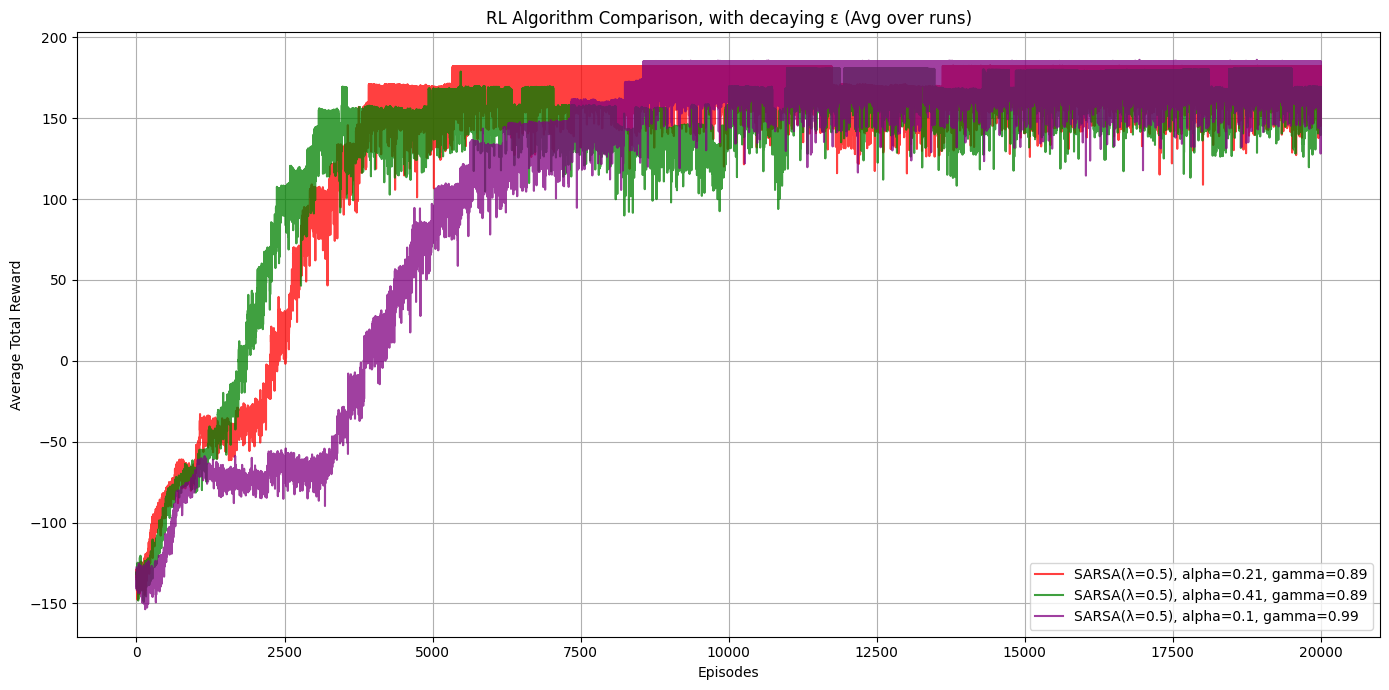

In [ ]:
compare_multiple_sarsa_lambda_algorithms(make_env, episodes=20000, runs=20, alphas=[0.21, 0.41, 0.1], gammas=[0.89, 0.89, 0.99], lambda_=0.5)

It is here that **we see the shortcomings of a higher learning rate**. Although the best converging SARSA($\lambda^*=0.5$) algorithm tested, with $(\alpha, \gamma) = (0.41, 0.89)$, does indeed initially learn the quickest till 3000 episodes, it is subsequently destabilized by its higher learning rate. This is further implied by the next best algorithm tested, with $(\alpha, \gamma) = (0.21, 0.89)$, which follows a similar trajectory but is able to converge to a high average reward and mostly maintain it (although it still suffers from a minor destabilization around episode 12,000). Finally, although the original SARSA($\lambda^*=0.5$) algorithm we have been using is a slow learner, it is able to maintain its converged reward very well.

This analysis therefore poses an interesting last promising optimisation investigation: **benchmarking a SARSA($\lambda^*=0.5$) algorithm, with $\gamma=0.89$ but geometrically decaying $\alpha$, against the original SARSA($\lambda^*=0.5$) algorithm**. The purpose of this would be to exploit a high learning rate initially, so as to converge quicker, and then maintain this converged reward with a lower learning rate over the latter length of training episodes.

In [301]:
###########################################
### SARSA(λ) Algorithm, with decaying α ###
###########################################

alpha_max = 0.4
alpha_min = 0.1
alpha_decay_rate = 0.995

def train_sarsa_lambda_decaying_alpha(env_factory, episodes, runs, gamma, lambda_):
    rewards_per_episode = np.zeros(episodes)
    Q_final_list = []
    final_rewards = []

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        Q = defaultdict(float)
        env = env_factory()
        run_rewards = []

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            alpha = max(alpha_min, alpha_max * (alpha_decay_rate ** ep))
            state = discretize_state(env.reset())
            a_idx = epsilon_greedy(Q, state, epsilon)

            E = defaultdict(float)  # Eligibility traces

            done = False
            total_reward = 0
            steps = 0
            max_steps = 500

            while not done and steps < max_steps:
                action = action_space[a_idx]
                next_state_raw, reward, done, _ = env.step(action)
                next_state = discretize_state(next_state_raw)
                next_a_idx = epsilon_greedy(Q, next_state, epsilon)

                delta = reward + gamma * Q[(next_state, next_a_idx)] - Q[(state, a_idx)]

                # Replace trace
                E[(state, a_idx)] = 1.0

                # Update all Q values, but also:
                # prune eligibility traces and update only significant ones
                prune_threshold = 1e-4  # anything smaller is discarded essentially

                for key in list(E.keys()):
                    Q[key] += alpha * delta * E[key]
                    E[key] *= gamma * lambda_

                    # Prune trace if it's too small
                    if abs(E[key]) < prune_threshold:
                        del E[key]


                state = next_state
                a_idx = next_a_idx
                total_reward += reward
                steps += 1

            run_rewards.append(total_reward)
            rewards_per_episode[ep] += total_reward

        Q_final_list.append(copy.deepcopy(Q))

        N = 100
        avg_final_reward = np.mean(run_rewards[-N:])
        final_rewards.append(avg_final_reward)

    rewards_per_episode /= runs

    best_idx = np.argmax(final_rewards)
    best_Q = Q_final_list[best_idx]

    return best_Q, rewards_per_episode

In [302]:
def compare_multiple_sarsa_lambda_algorithms_final(env_factory, episodes, runs, alpha, gammas, lambda_):
    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda1 = train_sarsa_lambda(env_factory, episodes, runs, alpha, gammas[0], lambda_)

    # Run SARSA(λ)
    print("\nTraining SARSA(λ)...")
    _, rewards_sarsalambda2 = train_sarsa_lambda_decaying_alpha(env_factory, episodes, runs, gammas[1], lambda_)

    # Plot all results
    plt.figure(figsize=(14, 7))
    plt.plot(rewards_sarsalambda1, label=f"SARSA(λ={lambda_}), alpha={alpha}, gamma={gammas[0]}", color='red', alpha=0.75)
    plt.plot(rewards_sarsalambda2, label=f"SARSA(λ={lambda_}), decaying alpha: ({alpha_max}-->{alpha_min}), gamma={gammas[1]}", color='green', alpha=0.75)

    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title("RL Algorithm Comparison, with decaying ε (Avg over runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training SARSA(λ)...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20

Training SARSA(λ)...
Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20


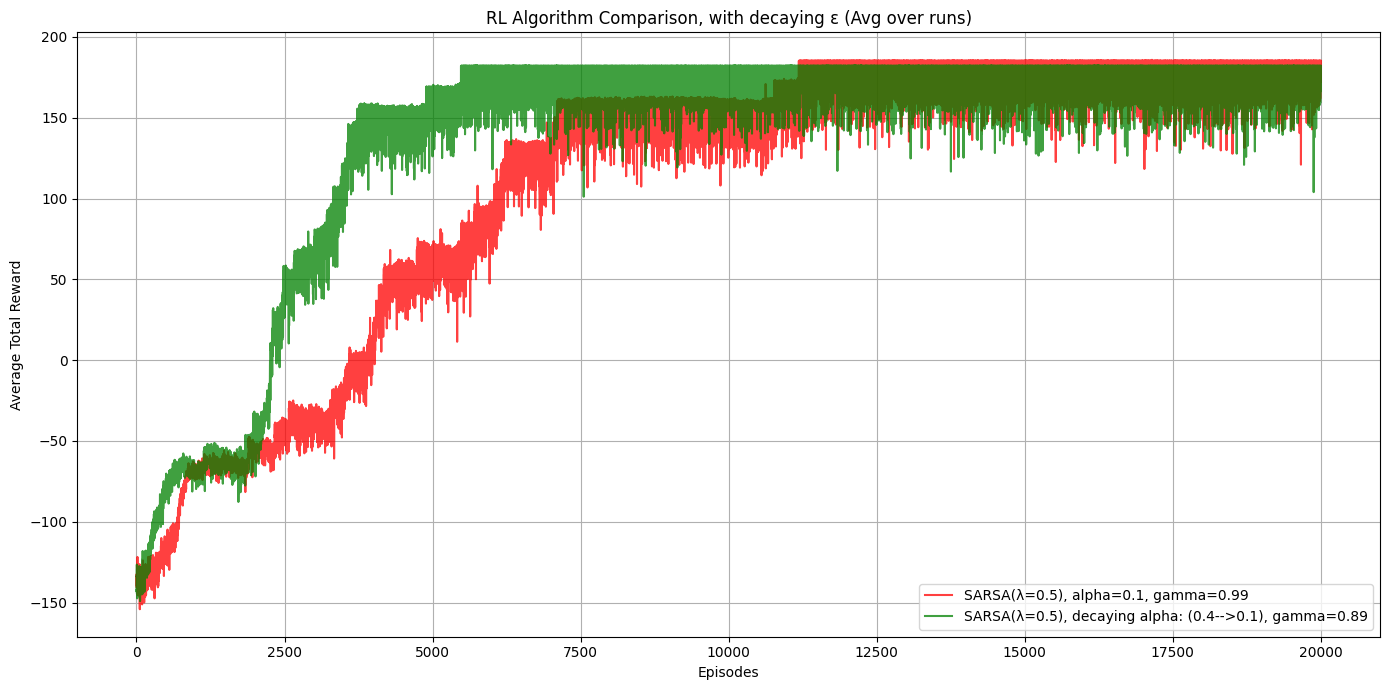

In [303]:
compare_multiple_sarsa_lambda_algorithms_final(make_env, episodes=20000, runs=20, alpha=0.1, gammas=[0.99, 0.89], lambda_=0.5)

From the above plot, we can now **infer the effect of the decaying $\alpha$ strategy as a positive one**; initially, such an algorithm exploits its high learning rate, whilst having relative stability over the latter half of training episodes as its learning rate decays to a more stable value.

Nonetheless, there is still a very minor distinction between this optimised SARSA($\lambda^*=0.5$) and the original one implemented, likely due to slight nuances in actions at particular states. This supports the idea that a very high gamma (e.g., 0.99) encourages the agent to consider the long-term consequences of its actions, even if those consequences are delayed.  

As a result, although **our optimisation has led to significant gains in convergence speed**, for the purposes of illustrating and visualising the best-performing TD learning agent, we shall retain the original SARSA($\lambda^*=0.5$) algorithm trained, with parameters $(\alpha, \gamma) = (0.1, 0.99)$.

##### **2.1.4: Visualising the Best-Performing TD Learning Agent**

We now visualise the best-performing SARSA($\lambda^*=0.5$) algorithm trained, with parameters $(\alpha, \gamma) = (0.1, 0.99)$.

In [310]:
best_Q_table, rewards_best_sarsalambda = train_sarsa_lambda(make_env, episodes=20000, runs=20, alpha=0.1, gamma=0.99, lambda_=0.5)

Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20


Total reward: 202.01304114821912, Steps taken: 37


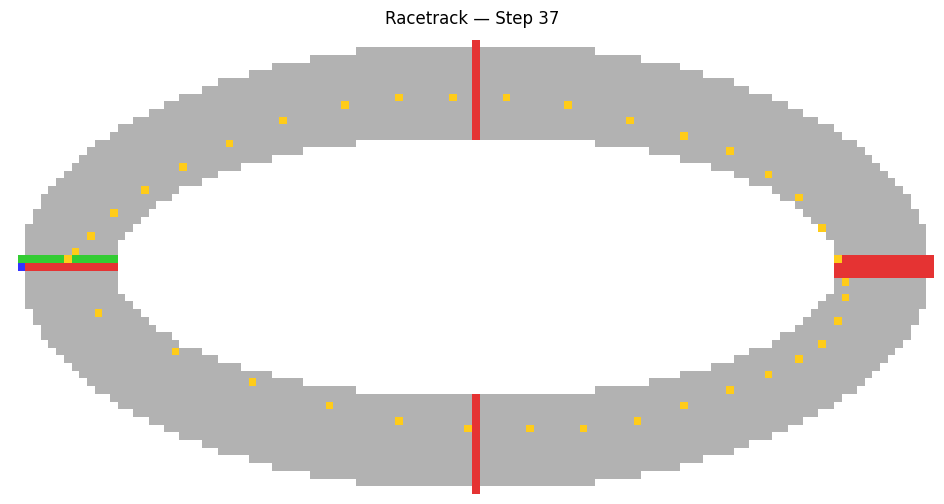

In [ ]:
def greedy_action(Q, state):
    q_vals = [Q.get((state, a), 0.0) for a in range(len(action_space))]
    max_q = max(q_vals)
    best_actions = [a for a, q in enumerate(q_vals) if q == max_q]
    return random.choice(best_actions)

def run_sarsa_policy_visual(Q, env):
    state = discretize_state(env.reset())
    done = False
    total_reward = 0
    step = 0
    max_steps = 100

    while not done and step < max_steps:
        a_idx = greedy_action(Q, state)  # use policy to select action
        action = action_space[a_idx]

        next_state_raw, reward, done, _ = env.step(action)
        state = discretize_state(next_state_raw)
        total_reward += reward
        step += 1

    print(f"Total reward: {total_reward}, Steps taken: {step}")
    env.render()  # we only need to render the final state


env = RacetrackEnv('oval')  # a fresh environment
run_sarsa_policy_visual(best_Q_table, env)


This final frame shows that the SARSA($\lambda^*=0.5$) agent has learned a racing strategy that **closely mirrors real-world behaviour; specifically, apexing**. In racing, taking the apex means following the innermost line through a corner to minimize travel distance and maintain speed. The agent appears to apply this by cutting corners effectively, reducing the number of steps needed to complete the lap.

Completing the track in just 37 steps suggests that the agent has found an efficient trajectory. This reflects how the optimized SARSA($\lambda$) policy, trained with a decaying ε and tuned hyperparameters, balances speed and control by favouring the shortest, most direct paths through curves.

Overall, this output confirms that the **agent has not only learned to finish the track, but to do so with a trajectory that resembles expert racing behaviour**. This is a strong indication of both effective learning and the emergence of practical strategy; most importantly, a successful realization of this project's goal within the single-agent reinforcement learning framework.

#### **2.2: Multi-Agent Reinforcement Learning (MARL) Approach**



In both real-world and game settings, autonomous vehicles rarely act in isolation: they must not only navigate the track, but also react to other drivers. Here we consider a two-car scenario using Multi-Agent Reinforcement Learning (MARL) methods. This allows for the extension of our single-agent framework, whereby **multiple agents concurrently learn in the same environment**. We adopt the Independent Learners strategy, in which each agent disregards the existence of the other agents and estimates its action-value function using only its own observed states, actions, and rewards (Gronauer & Diepold, 2022). Other agents are observed as part of the environment. As various agents dynamically interact with the environment, the state-transitions evolve over time, introducing an element of non-stationarity to the environment. Therefore, Independent Learners violate a key assumption of Markov Decision Processes (Lee et al., 2022). Though naive, the Independent Learners approach provides a valuable insight into core multi-agent dynamics.

##### **2.2.1: Environment Adaptations for MARL**

To implement the Independent Learners algorithm, we modified our base environment in the following ways:

- **Collision Handling**: If the trajectories of two agents intersect, they are considered as have collided. This results in the termination of the episode, and the agents incur a large negative penalty of -100.

- **Multi-Agent Initialisation and Logic**: The environment allows for several agents, and relies on vectorised logic to handle multiple agents simultaneously.

- **Reduced Step Penalty**: The step penalty was reduced. This prevents agents from favouring early crashes (to avoid further step penalties) over completing a full circuit.

- **Proximity Bonus Shaping**: Agents earn a small positive reward proportional to the distance they maintain from other cars, allowing agents to learn safer trajectories.

- **First to Checkpoint Bonus**: The first agent to cross a checkpoint gets a small bonus of 10 points. This is to encourage a competitive aspect of the game, even if agents are unable to directly compete.


In [326]:
##########################################
### Environment Adaptations for MARL ###
#########################################

# Agent/Car class
class RacetrackCar:
    def __init__(self, start_positions):
        """ 
        agents_start_pos: a list of (x, y) tuples indicating the initial positions of the agents. 
        """
        self.num_agents = len(start_positions)
        self.x = [pos[0] for pos in start_positions]
        self.y = [pos[1] for pos in start_positions]
        self.vx = [0] * self.num_agents
        self.vy = [0] * self.num_agents

    def apply_actions(self, actions):
        """
        actions: a list of actions as (vx, vy) tuples, one per agent.
        """
        for i in range(self.num_agents): 
            self.vx[i] += actions[i][0]
            self.vy[i] += actions[i][1]
            self.x[i] += self.vx[i]
            self.y[i] += self.vy[i]
        return [(self.x[i], self.y[i], self.vx[i], self.vy[i]) for i in range(self.num_agents)]

    def reset(self, positions):
        """
        positions: list of (x, y) tuples, one per agent.
        """
        self.x = [pos[0] for pos in positions]
        self.y = [pos[1] for pos in positions]
        self.vx = [0] * self.num_agents
        self.vy = [0] * self.num_agents
        return [(self.x[i], self.y[i], self.vx[i], self.vy[i]) for i in range(self.num_agents)]

# Adjusted Environment Class
class RacetrackEnv:
    def __init__(self, map_name='oval', num_agents = 2):
        # The number of agents involved in MARL is a new attribute. 
        # Reading in the map remains the same as before. 
        self.num_agents = num_agents

        if map_name == 'oval':
            self.map = generate_oval_track()
        else:
            raise NotImplementedError("Only procedural oval supported.")

        # Positions
        self.start_positions = [(x, y) for y, x in zip(*np.where(self.map == START))]
        self.checkpoint_positions = set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)))
        self.track_positions = set((x, y) for y, x in zip(*np.where(self.map == TRACK)))

        self.walls = set()

        # Ordered checkpoint zones (manually grouped by x,y regions)
        cx, cy = self.map.shape[1] // 2, self.map.shape[0] // 2
        self.checkpoints = [
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if x == cx and y < cy),  # vertical top center
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if y == cy and x > cx),  # right horizontal center
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if x == cx and y > cy),  # vertical bottom center
            set((x, y) for y, x in zip(*np.where(self.map == CHECKPOINT)) if y == cy and x < cx),  # left horizontal center
        ]
        self.total_checkpoints = len(self.checkpoints)

        self.checkpoint_idxs = [0] * self.num_agents
        self.cars = None
        self.dones = [False] * self.num_agents
        self.rewards = [0] * self.num_agents
        self.step_counts = [0] * self.num_agents
        self.trails = [[] for i in range(self.num_agents)]

    def reset(self):
        starts = random.sample(self.start_positions, k=self.num_agents)
        self.cars = RacetrackCar(starts)
        self.dones = [False] * self.num_agents
        self.rewards = [0] * self.num_agents
        self.step_counts = [0] * self.num_agents
        self.checkpoint_idxs = [0] * self.num_agents
        self.trails = [[pos] for pos in starts]
        return self.get_states()

    def get_states(self):
        return [(self.cars.x[i], self.cars.y[i], self.cars.vx[i], self.cars.vy[i]) for i in range(self.num_agents)]

    def is_on_track(self, x, y):
        return (x, y) in self.track_positions or (x, y) in self.checkpoint_positions or (x, y) in self.start_positions

    def step(self, actions):
        """
        actions: a list of actions as (vx, vy) tuples, one per agent.
        """

        # If one agent has crashed, it stops moving while the others continue. 
        for i in range(self.num_agents):
            if self.dones[i]:
                self.cars.vx[i] = 0
                self.cars.vy[i] = 0
                actions[i] = (0, 0)

        for i in range(self.num_agents):
            self.step_counts[i] += 1

        old_positions = [(self.cars.x[i], self.cars.y[i]) for i in range(self.num_agents)]
        new_states = self.cars.apply_actions(actions)

        all_path_cells = [get_path_cells(old_positions[i][0], old_positions[i][1], 
                                        new_states[i][0], new_states[i][1])
                         for i in range(self.num_agents)]

        for i, (x, y, vx, vy) in enumerate(new_states):
            self.trails[i].append((x, y))

        self.rewards = [0] * self.num_agents

        # If the agents crash into one another, they are done for the episode and recieve a large negative reward. 
        for i in range(self.num_agents):
            for j in range(i+1, self.num_agents):
                if set(all_path_cells[i]).intersection(all_path_cells[j]):
                    self.dones[i]   = True
                    self.dones[j]   = True
                    self.rewards[i] = -100
                    self.rewards[j] = -100

        # A minimum proximity bonus is added if the cars stay > 2 cells away from each other. 
        # This trains them to learn to avoid crashing into one another. 
        unsafe_radius = 2 

        for i in range(self.num_agents):
            for j in range(i+1, self.num_agents):
                if not (self.dones[i] or self.dones[j]): 
                    xi, yi, _, _ = new_states[i]
                    xj, yj, _, _ = new_states[j]
                    d = ((xi-xj)**2 + (yi-yj)**2)**0.5
                    bonus = min( (d - unsafe_radius) / unsafe_radius, 1.0 ) * 2.0
                    if d > unsafe_radius: 
                        self.rewards[i] += bonus
                        self.rewards[j] += bonus

        prev_idxs = self.checkpoint_idxs.copy()

        for i in range(self.num_agents): 
            if self.dones[i]: 
                continue

            old_x, old_y = old_positions[i]
            x, y, vx, vy = new_states[i]

            # Progress reward for moving towards next target checkpoint
            checkpoint = list(self.checkpoints[min(self.checkpoint_idxs[i], self.total_checkpoints - 1)])[0]
            prev_dist = np.linalg.norm(np.array([old_x, old_y]) - np.array(checkpoint))
            new_dist = np.linalg.norm(np.array([x, y]) - np.array(checkpoint))
            self.rewards[i] = (prev_dist - new_dist) * 1.0
        
            # Step penalty to encourage efficiency
            self.rewards[i] -= 2

            # Crash check and penalty 
            if not (0 <= x < self.map.shape[1] and 0 <= y < self.map.shape[0]) or not self.is_on_track(x, y):
                self.dones[i] = True
                self.rewards[i] = -100
                continue 

            # Check path cells
            path_cells = all_path_cells[i]

            # Reached correct checkpoint
            if self.checkpoint_idxs[i] < self.total_checkpoints:
                target_zone = self.checkpoints[self.checkpoint_idxs[i]]
                if any(cell in target_zone for cell in path_cells):
                    # The agent gets a reward if it is the first to cross a checkpoint. 
                    if prev_idxs[i] == max(prev_idxs):
                        self.rewards[i] += 10
                    self.checkpoint_idxs[i] += 1
                    self.rewards[i] += 20

                # big reward if agent reaches last checkpoint/finish line
                if self.checkpoint_idxs[i] >= self.total_checkpoints:
                    self.dones[i] = True
                    self.rewards[i] += 100

            # We have to account for exploiting checkpoints:
            # 1. Reached previous checkpoint (backward)
            elif any(cell in zone for zone in self.checkpoints[:self.checkpoint_idxs[i]] for cell in path_cells):
                self.rewards[i] -= 20

            # 2. Skipped ahead
            elif any(cell in zone for zone in self.checkpoints[self.checkpoint_idxs[i] + 1 :] for cell in path_cells):
                self.rewards[i] -= 50

        return self.get_states(), self.rewards, self.dones, {}

    def render(self):
        colours = [
            (1.0, 0.0, 1.0),   # magenta
            (0.0, 1.0, 1.0),   # cyan
            (0.2, 0.8, 0.2),   # green
            (1.0, 1.0, 0.2),   # yellow
        ][:self.num_agents]   

        img = np.zeros((*self.map.shape, 3))
        color_map = {
            EMPTY: (1, 1, 1),
            TRACK: (0.7, 0.7, 0.7),
            START: (0.2, 0.8, 0.2),
            CHECKPOINT: (0.9, 0.2, 0.2),
        }

        # Base map
        for y in range(self.map.shape[0]):
            for x in range(self.map.shape[1]):
                img[y, x] = color_map.get(self.map[y, x], (0, 0, 0))

        # Highlight active checkpoint
        next_idx = min(self.checkpoint_idxs)
        for i, zone in enumerate(self.checkpoints):
            for x, y in zone:
                if i == next_idx:
                    img[y, x] = (1.0, 0.5, 0.0)  # Orange, if it is the next checkpoint to be targeted
                else:
                    img[y, x] = (0.9, 0.2, 0.2)  # Red, otherwise

        # Draw trail 
        for i, trail in enumerate(self.trails):
            colour = colours[i]
            for (x, y) in trail:
                if 0 <= x < self.map.shape[1] and 0 <= y < self.map.shape[0]:
                    img[y, x] = colour

        plt.figure(figsize=(12, 6))
        plt.imshow(img, origin='upper')
        plt.axis('off')

        plt.show()

    def build_image(self):
        """Return the H×W×3 NumPy array for the current map + trails."""
        colours = [
            (1.0, 0.0, 1.0),  # magenta
            (0.0, 1.0, 1.0),  # cyan
            (0.2, 0.8, 0.2),  # green
            (1.0, 1.0, 0.2),  # yellow
        ][:self.num_agents]

        img = np.zeros((*self.map.shape, 3))
        color_map = {
            EMPTY: (1, 1, 1),
            TRACK: (0.7, 0.7, 0.7),
            START: (0.2, 0.8, 0.2),
            CHECKPOINT: (0.9, 0.2, 0.2),
        }

        # Base map
        for y in range(self.map.shape[0]):
            for x in range(self.map.shape[1]):
                img[y, x] = color_map.get(self.map[y, x], (0, 0, 0))

        # Highlight active checkpoint
        next_idx = min(self.checkpoint_idxs)
        for i, zone in enumerate(self.checkpoints):
            for x, y in zone:
                img[y, x] = (1.0, 0.5, 0.0) if i == next_idx else (0.9, 0.2, 0.2)

        # Draw trails
        for i, trail in enumerate(self.trails):
            colour = colours[i]
            for (x, y) in trail:
                if 0 <= x < self.map.shape[1] and 0 <= y < self.map.shape[0]:
                    img[y, x] = colour

        return img


##### **2.2.2: MARL Implementation with Q-Learning and SARSA(λ)**

We applied the two most effective algorithms, **Q-Learning** and **SARSA($\lambda$)**, in the multi-agent setting. We performed a simple hyperparameter sweep over $\epsilon$-decay rates, using the average total reward over runs to gauge performance.

We found that a slower decay rate of $\epsilon = 0.99999$ resulted in higher mean returns, while faster decay rates led to the algorithms plateauing at suboptimal policies. This adjustment derives from the non-stationary nature of multi-agent reinforcement learning (MARL). As Buşoniu et al. (2010) observe: *“Each agent is therefore faced with a moving-target learning problem: the best policy changes as the other agents’ policies change.”* (p. 7).

If $\epsilon$ decays too quickly, an agent may prematurely converge to a policy suited to its peers’ earlier behaviour. Maintaining an element of exploration allows agents to continue exploring and refining their Q-function estimates to the evolving environment.


In [327]:
# 1. MARL with SARSA(λ)
def sarsa_lam_MARL(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99, lambda_=0.5):
    num_agents = env_factory().num_agents

    rewards_per_episode = [np.zeros(episodes) for i in range(num_agents)]
    Q_final_list = [[] for i in range(num_agents)]
    final_rewards = [[] for i in range(num_agents)]

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        Q = [defaultdict(float) for i in range(num_agents)]
        env = env_factory()
        run_rewards = [[] for i in range(num_agents)]

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            states = [discretize_state(s) for s in env.reset()]
            a_idxs = [epsilon_greedy(Q[i], states[i], epsilon) for i in range(num_agents)]

            E = [defaultdict(float) for i in range(num_agents)]  # Eligibility traces

            dones = [False] * num_agents
            total_rewards = [0] * num_agents
            steps = [0] * num_agents
            max_steps = 100

            while not all(dones) and max(steps) < max_steps:
                actions = [action_space[a_idxs[i]] for i in range(num_agents)]
                next_states_raw, rewards, dones, _ = env.step(actions)
                next_states = [discretize_state(s) for s in next_states_raw]
                next_a_idxs = [epsilon_greedy(Q[i], next_states[i], epsilon) for i in range(num_agents)]

                for i in range(num_agents): 
                    total_rewards[i] += rewards[i]
                    
                    if dones[i]: 
                        E[i].clear()
                        continue 

                    delta = rewards[i] + gamma * Q[i][(next_states[i], next_a_idxs[i])] - Q[i][(states[i], a_idxs[i])]

                    # Replace trace
                    E[i][(states[i], a_idxs[i])] = 1.0

                    # Update all Q values, but also:
                    # prune eligibility traces and update only significant ones
                    prune_threshold = 1e-4  # anything smaller is discarded essentially

                    for key in list(E[i].keys()):
                        Q[i][key] += alpha * delta * E[i][key]
                        E[i][key] *= gamma * lambda_

                        # Prune trace if it's too small
                        if abs(E[i][key]) < prune_threshold:
                            del E[i][key]

                    states[i] = next_states[i]
                    a_idxs[i] = next_a_idxs[i]
                    steps[i] += 1

            N = 50

            for i in range(num_agents):
                run_rewards[i].append(total_rewards[i])
                rewards_per_episode[i][ep] += total_rewards[i]

        for i in range(num_agents): 
            Q_final_list[i].append(copy.deepcopy(Q[i]))
            final_rewards[i].append(np.mean(run_rewards[i][-N:]))

    best_Q = []
    for i in range(num_agents):
        rewards_per_episode[i] /= runs
        best_idx = np.argmax(final_rewards[i])
        best_Q.append(Q_final_list[i][best_idx])

    return best_Q, rewards_per_episode

# 2. MARL with Q-Learning 
def qlearning_MARL(env_factory, episodes=200, runs=10, alpha=0.1, gamma=0.99,):
    num_agents = env_factory().num_agents

    rewards_per_episode = [np.zeros(episodes) for i in range(num_agents)]
    Q_final_list = [[] for i in range(num_agents)]
    final_rewards = [[] for i in range(num_agents)]

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        Q = [defaultdict(float) for i in range(num_agents)]
        env = env_factory()
        run_rewards = [[] for i in range(num_agents)]

        for ep in range(episodes):
            epsilon = max(epsilon_min, epsilon_start * (decay_rate ** ep))
            states = [discretize_state(s) for s in env.reset()]
            a_idxs = [epsilon_greedy(Q[i], states[i], epsilon) for i in range(num_agents)]

            dones = [False] * num_agents
            total_rewards = [0] * num_agents
            steps = [0] * num_agents
            max_steps = 100

            while not all(dones) and max(steps) < max_steps:
                actions = [action_space[a_idxs[i]] for i in range(num_agents)]
                next_states_raw, rewards, dones, _ = env.step(actions)
                next_states = [discretize_state(s) for s in next_states_raw]

                for i in range(num_agents):
                    total_rewards[i] += rewards[i]
                     
                    if dones[i]: 
                        continue 
                    
                    max_next_Q = max(Q[i][(next_states[i], a)] for a in range(len(action_space)))
                    Q[i][(states[i], a_idxs[i])] += alpha * (
                    rewards[i] + gamma * max_next_Q - Q[i][(states[i], a_idxs[i])]
                    )

                    # Choose next action using epsilon-greedy
                    next_a_idx = epsilon_greedy(Q[i], next_states[i], epsilon)

                    a_idxs[i] = next_a_idx
                    states[i] = next_states[i]
                    steps[i] += 1

            N = 50

            for i in range(num_agents):
                run_rewards[i].append(total_rewards[i])
                rewards_per_episode[i][ep] += total_rewards[i]

        for i in range(num_agents): 
            Q_final_list[i].append(copy.deepcopy(Q[i]))
            final_rewards[i].append(np.mean(run_rewards[i][-N:]))

    best_Q = []
    for i in range(num_agents):
        rewards_per_episode[i] /= runs
        best_idx = np.argmax(final_rewards[i])
        best_Q.append(Q_final_list[i][best_idx])

    return best_Q, rewards_per_episode

In [ ]:
epsilon_start = 0.1
epsilon_min = 0.001
decay_rate = 0.99999

def plot_MARL(rewards, title): 
    plt.figure(figsize=(14, 7))
    plt.plot(rewards[0], label="Agent 1", color='cyan', alpha=0.6)
    plt.plot(rewards[1], label="Agent 2", color='magenta', alpha=0.6)

    plt.xlabel("Episodes")
    plt.ylabel("Average Total Reward")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

best_Qs_sarsalam, rewards_per_episode_MARL_sarsalam = sarsa_lam_MARL(make_env, episodes=50000, lambda_=0.5)
best_Qs_q, rewards_per_episode_MARL_q = qlearning_MARL(make_env, episodes= 500000, alpha = 0.1)

plot_MARL(rewards_per_episode_MARL_sarsalam, "Multi-Agent RL with SARSA(λ)")
plot_MARL(rewards_per_episode_MARL_q, "Multi-Agent RL with Q-Learning")

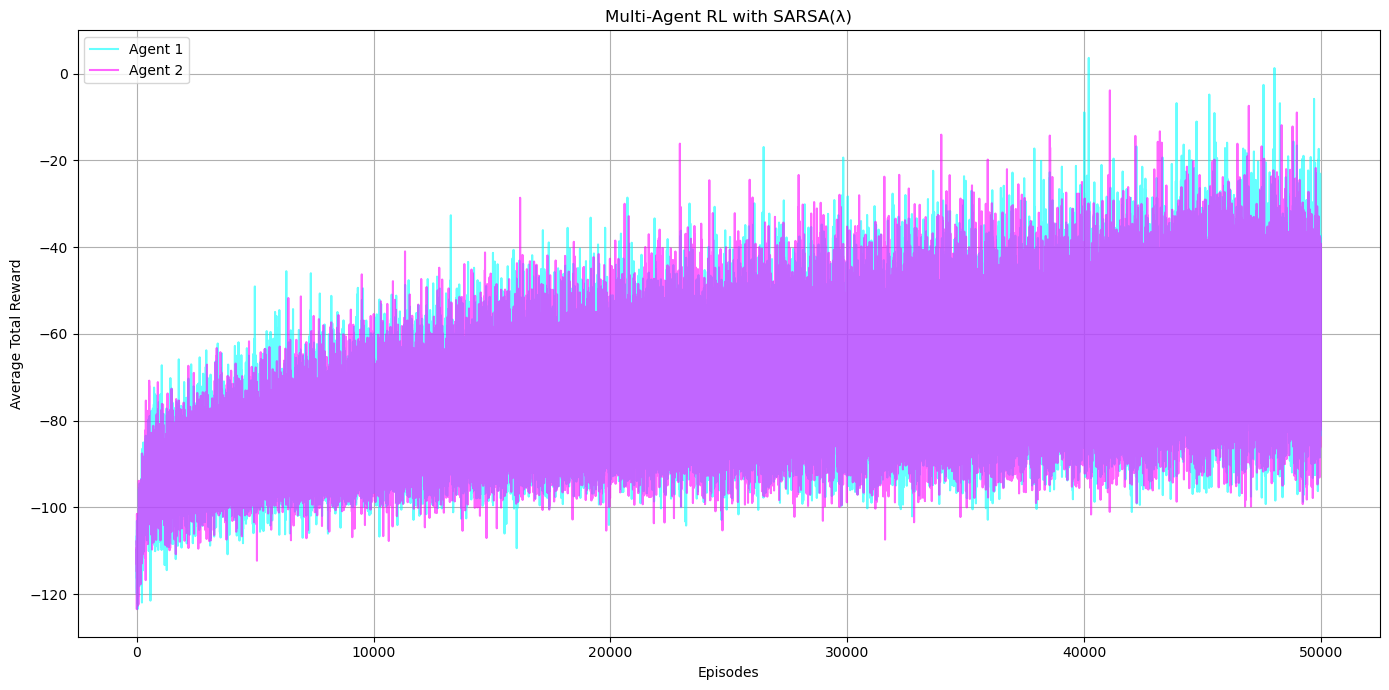

In [331]:
display.Image(data="pictures/MARL_SARSA_lambda.png", width=1200, height=300)

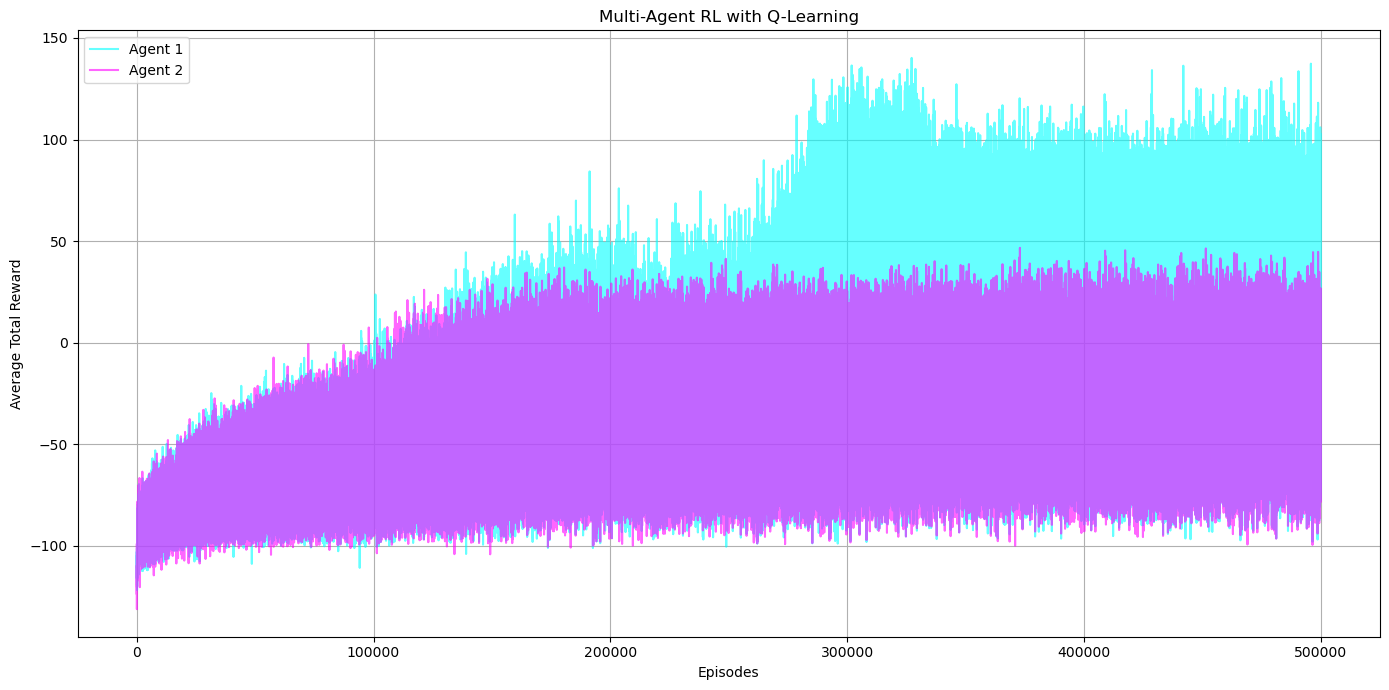

In [332]:
display.Image(data="pictures/MARL_Q_learning.png", width=1200, height=300)

As seen in the above plot, the average return under SARSA($\lambda$) in a multi-agent setting are initially strongly negative, but gradually climb and plateau around -30. Experiments with extended training (up to 500,000 episodes per run) reveal that the average rewards do not improve far beyond this level. This indicates that the agents under **SARSA($\lambda$) never learn to complete a full lap around the track. This may be due to the fact that SARSA($\lambda$) is an on-policy method**. If the agent takes a suboptimal move early on in training, this can depress the Q-value for that state-action pair. In such a high-dimensional state-space, these entries may never be revisited. However, the same state-action pair may be critical for avoiding the other agents in later episodes. 

In contrast, MARL with Q-Learning has steeply negative returns initially, but steadily improves over 500,000 episodes, eventually resulting in some episodes with positive rewards up to $\sim$100. This evidences that after training, some episodes resulted in successful laps around the track. However, the large discrepancy between the training length in single-agent and multiple-agent Q-learning should be noted. While standard Q-learning reliably converges after less than 10,000 episodes, the multi-agent version requires 500,000 episodes to even approach a modest reward threshold. Furthermore, the breadth of rewards remains quite large, ranging from -100 to 100 even after 500,000 episodes. This implies that neither agent fully converges to the optimal policy; even after training, the agents still cannot avoid fatal errors. Thus, **while Q-Learning shows more promising results in a MARL environment, it still cannot overcome the issue of non-stationarity**.

While the 'First to Checkpoint' bonus did not impact the SARSA($\lambda$) results, one agent can dominate over the other in the Q-Learning environment. The 'First to Checkpoint' bonus allows for competition between agents, as it provides a small incentive to complete the track more efficiently than the co-learners on the track. If one agent discovers the potential bonus in earlier episodes, it may reinforce future behaviour to ensure first-to-checkpoint tactics. Over time, this results in a steep advantage in cumulative rewards.

The impact of this bonus can be seen in the example trajectories below:

In [336]:
from IPython.display import HTML
HTML('<img src="multi_agent.gif">')

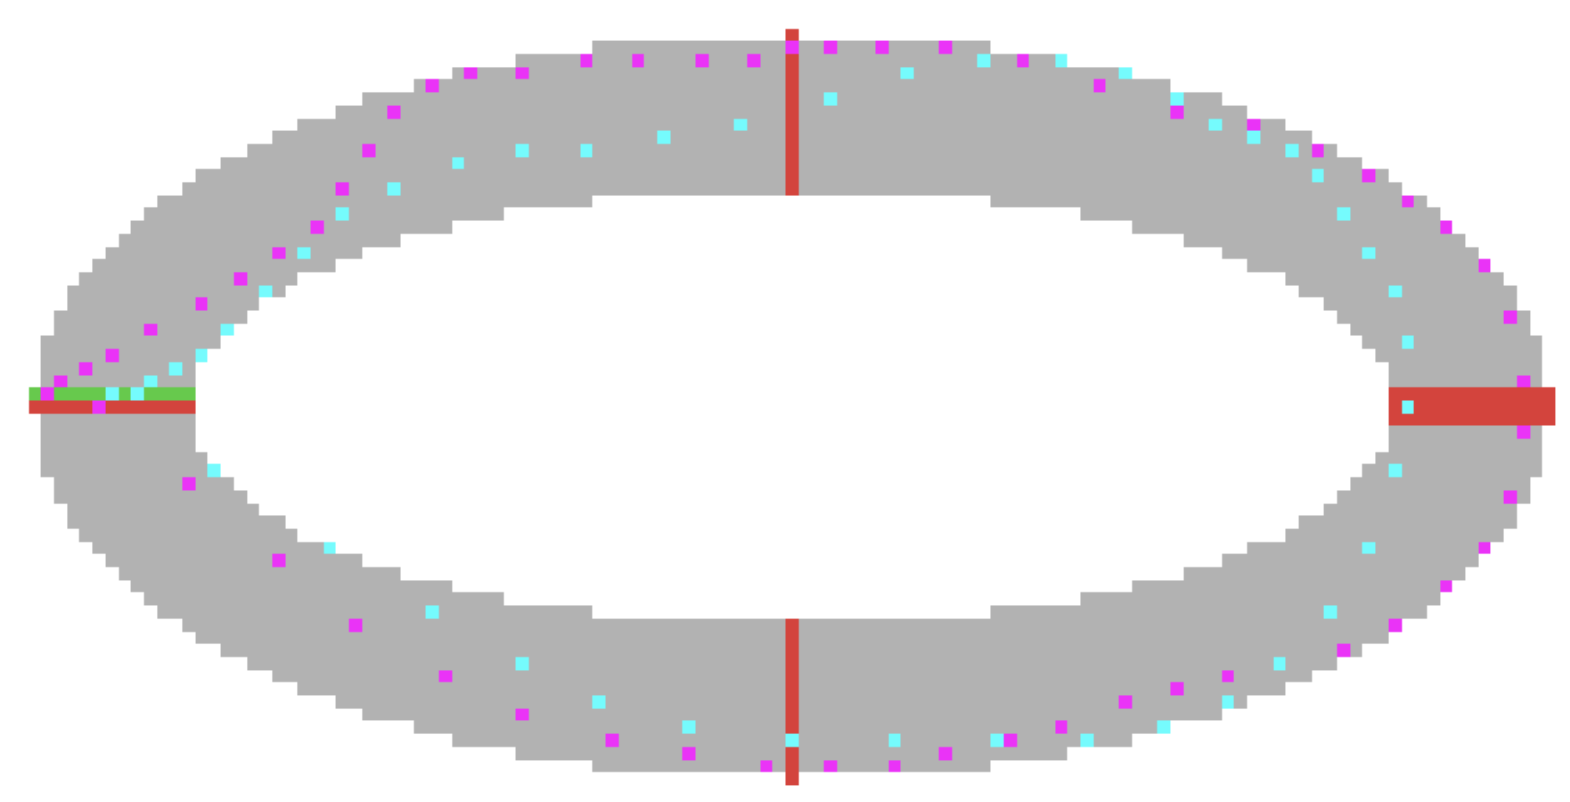

In [334]:
display.Image(data="pictures/MARL_Complete.png", width=1200, height=300)

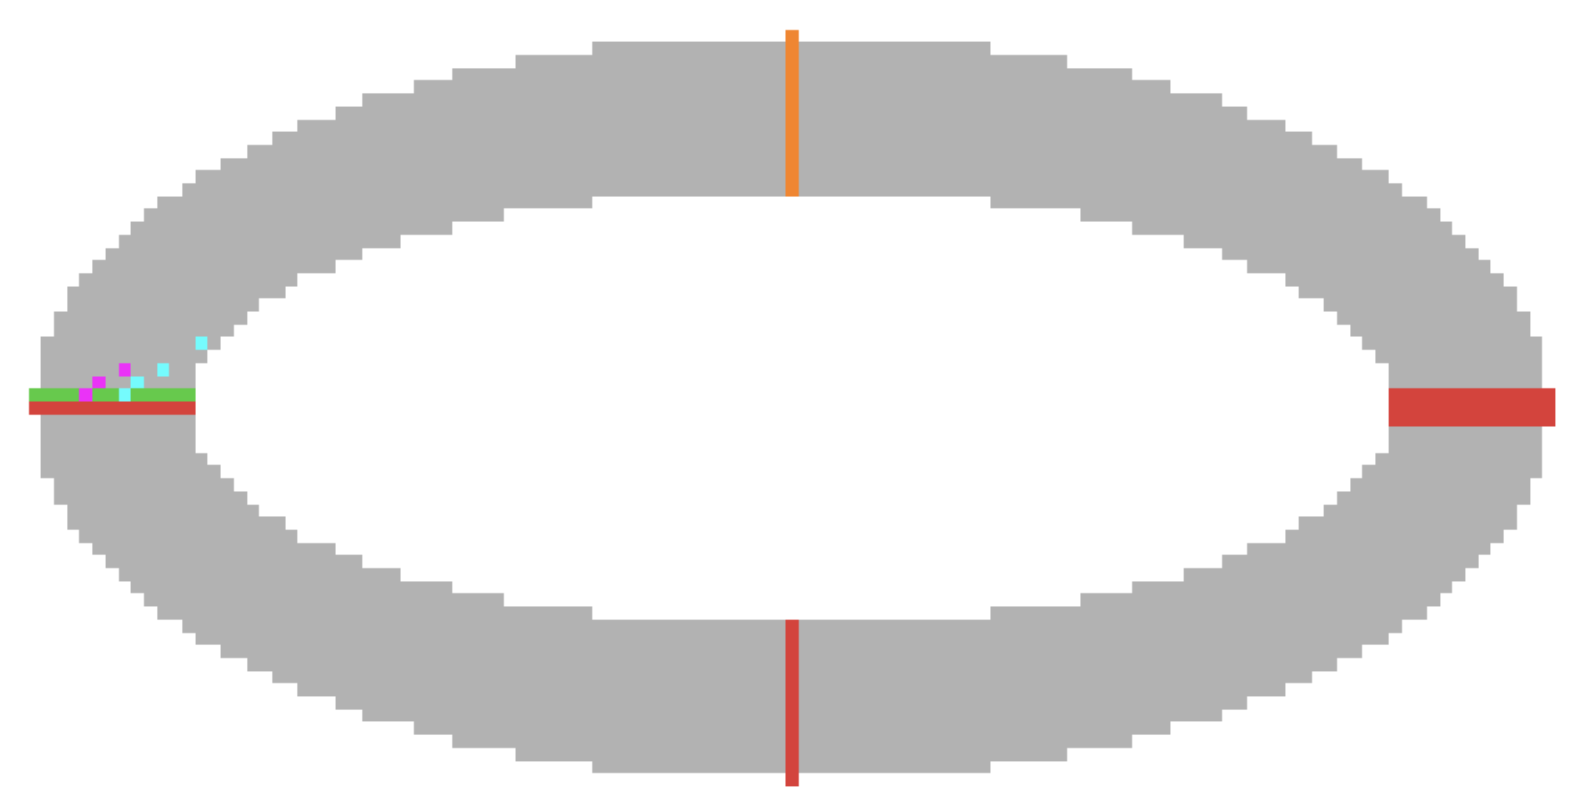

In [335]:
display.Image(data="pictures/MARL_Incomplete.png", width=1200, height=300)

*Sample Trajectories under the Q-Learning Independent Learners Model.*

Each of these panels shows a single episode, rendered after training. The trajectories of Agent 1 (Cyan) and Agent 2 (Magenta) are displayed on the track.

**Top Panel**: In this episode, both cars complete a full lap and recieve positive net returns.

**Bottom Panel**: In this episode, both cars collide at the right-most cyan point. Even after training, the agents do not succeed every time. While they have learnt to navigate the track, they still have issues navigating around one another.

### **3 Discussion**

This project set out to explore the capabilities of Reinforcement Learning (RL) algorithms in learning optimal racing lines in a procedurally generated racetrack environment. We considered both single-agent and multi-agent settings, employing temporal difference (TD) learning methods such as SARSA, Q-learning, SARSA($\lambda$), and Double Q-learning. Across both scenarios, the goal remained consistent: to train agents that not only complete laps successfully but also do so efficiently, minimizing the number of steps while maximizing cumulative reward.

In the single-agent context, we observed that all algorithms learned progressively more effective trajectories around the circuit. Of the methods tested, SARSA($\lambda$) emerged as the most effective when its $\lambda$ parameter was tuned through grid searching ($\lambda^*=0.5$). Its success over Q-learning and SARSA stemmed from its ability to balance immediate feedback with forward-looking credit assignment, allowing the agent to discover slight action refinements that shaved down lap times. Notably, SARSA($\lambda^*=0.5$) surpassed Q-learning in average performance, demonstrating faster convergence and better final rewards, despite its on-policy nature. Additonally, attempts were made to further optimise the SARSA($\lambda^*=0.5$) algorithm via the parameter set ($\alpha, \gamma$), and although it resulted in faster convergence, the original SARSA($\lambda^*=0.5$) algorithm with parameters $(\alpha, \gamma) = (0.1, 0.99)$ was retained as it still converged to a slightly higher average total reward; this was preferred over convergence speed, as the objective of this project was to find the best racing line approximation.

By contrast, the multi-agent setting introduced significant challenges due to the inherently non-stationary environment. Using Independent Learners, we trained two agents simultaneously without centralized coordination. This shift complicated the learning dynamics, as each agent's environment evolved with the other's changing policy. The results revealed a stark contrast in algorithm performance. SARSA($\lambda$), which previously performed well, now plateaued at suboptimal policies. As an on-policy method, SARSA($\lambda$) was more susceptible to becoming trapped in local minima early in training. The agents rarely completed laps successfully and maintained average returns around -30, even after extensive training.

Q-learning, on the other hand, proved more robust in this multi-agent environment. Though its learning curve was initially steep and required substantially more episodes to converge compared to the single-agent case, it eventually yielded occasional episodes of full-track completion and average rewards closer to zero or higher. This improvement reflects the benefit of off-policy learning, where agents can more freely explore and retain valuable experience without being overly constrained by their current policy. That said, even Q-learning's success was partial: high variance and occasional collisions persisted, demonstrating that Independent Learners are still fundamentally limited in stability and reliability.

### **4 Conclusion**

This project has provided a comprehensive investigation of TD learning in both single- and multi-agent racetrack environments. We have demonstrated that with the right hyperparameter tuning, particularly involving $\lambda$, $\alpha$, and $\gamma$, SARSA($\lambda$) can outperform other algorithms in single-agent settings by learning subtle trajectory optimizations. However, when extended to a competitive multi-agent domain, off-policy methods like Q-learning show greater resilience, albeit at the cost of longer training times and less consistent convergence.

The multi-agent adaptation also highlighted key engineering considerations, such as reward shaping and collision dynamics, that significantly influence learning. Incentives like proximity bonuses and checkpoint races provided rich feedback for agents to develop competitive but efficient behaviours.

Future directions may include replacing Independent Learners with centralized training approaches, such as centralized critics or shared policies, to better manage the non-stationarity of MARL environments. Alternatively, extending the current model to accommodate cooperative or team-based racing strategies could provide new insight into multi-agent collaboration. Overall, this project lays a robust foundation for understanding and developing both single-agent and multi-agent reinforcement learning strategies for learning optimal racing lines in discrete-space environments.

### **5 References**

Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). MIT Press.

Tingsong Ou (2023). Solving Reinforcement Learning Racetrack Exercise with Off-policy Monte Carlo Control. Artificial Intelligence, Towards Data Science. https://towardsdatascience.com/solving-reinforcement-learning-racetrack-exercise-building-the-environment-33712602de0c/

Buşoniu, L., Babuška, R., & De Schutter, B. (2010). Multi-agent reinforcement learning: An overview. In D. Srinivasan & L. C. Jain (Eds.), Innovations in multi-agent systems and applications—1 (Vol. 310, pp. 183–221). Springer. https://doi.org/10.1007/978-3-642-14435-6_7

Gronauer, S., & Diepold, K. (2022). Multi‐agent deep reinforcement learning: A survey. Artificial Intelligence Review, 55, 895–943. https://doi.org/10.1007/s10462-021-09996-w

Lee, K. M., Ganapathi Subramanian, S., & Crowley, M. (2022). Investigation of independent reinforcement learning algorithms in multi-agent environments. Frontiers in Artificial Intelligence, 5, Article 805823. https://doi.org/10.3389/frai.2022.805823

### **Appendix A: Definitions**

**SARSA**

SARSA (State–Action–Reward–State–Action) is an iterative, model-free, on-policy reinforcement learning algorithm that alternates between policy evaluation and policy improvement. The aim of the SARSA algorithm is to estimate the Q-function for the current policy $\pi$ (Sutton and Barto, 2018). In this Racetrack scenario, $\pi$ refers to the $\varepsilon$-greedy policy which balances exploration and exploitation. The Q-function is modelled in a tabular format, storing the expected return for each state-action pair. The action-value function is updated based on a quintuple of the current state $S_t$, the selected action $A_t$, the reward received $R_{t+1}$, the subsequent state $S_{t+1}$, and corresponding action $A_{t+1}$:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right].
$$

At each update, the expected future rewards of the current state-action pair are adjusted by the TD error, which measures the difference between the previous estimate and the current estimate of the Q-value. If $S_{t+1}$ is a terminal state, then $Q(S_{t+1}, A_{t+1}) = 0$. The discount factor $\gamma$ balances the importance of future versus immediate rewards, with $\gamma = 0$ representing an entirely myopic policy that only considers immediate rewards, while $\gamma = 1$ indicates that future and immediate rewards hold equal weight. The learning rate $\alpha$ controls how sensitive the updates are to the current reward and TD error, with a larger $\alpha$ placing more weight on recent experiences.

**SARSA($\lambda$)**

Similarly to SARSA, SARSA ($\lambda$) is an iterative, on-policy reinforcement learning algorithm that employs the same underlying update formula as standard SARSA. The differentiating factor between the two algorithms lies in the inclusion of eligibility traces. These eligibility traces are stored in a similar tabular format to the action-value function and keep a record of the state-action pairs that have been visited.

Eligibility traces decay over time by a rate governed by $\lambda$ and the discount factor $\gamma$. When $\lambda = 0$, this is equivalent to one-step SARSA. When $\lambda = 1$, this approximates Monte Carlo (MC) learning, where all rewards from an episode contribute equally to past states.

At each time step, every state-action pair that has previously been visited is updated using the SARSA mechanism, weighted by the value of its eligibility trace at that moment. In this case, we use an accumulating trace, meaning that a value of 1 is added to the eligibility trace of a state-action pair each time it is visited.

**Q-Learning**

Q-learning is an iterative, off-policy reinforcement learning algorithm. It is an off-policy algorithm; value estimates are updated according to the greedy action, irrespective of the action actually taken by the agent. The goal of Q-learning is to estimate the optimal Q-function, regardless of the behaviour policy that the agent follows (Sutton and Barto, 2018). As with SARSA, the action-value function is modelled in a tabular format, storing the expected return for each state-action pair. The update rule for Q-learning is as follows:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t) \right].
$$

The Q-function is adjusted according to the difference between the current estimate of the action-value, $Q(S_t, A_t)$, and the highest estimated action-value in the next state $Q(S_{t+1}, a)$. These updates are subject to the same discount factor ($\gamma$) and learning rate ($\alpha$) parameters as SARSA.

**Double Q-Learning**

An extension of Q-learning is Double Q-learning, which aims to reduce the maximisation bias faced by standard Q-learning. Two tabular estimates of the Q-function are maintained, $Q_1$ and $Q_2$. At each discrete time step, one estimate is used for the action selection process $\left(\max_a Q(S_{t+1}, a)\right)$, while the other is used as the action-value estimate $\left(Q(S_t, A_t)\right)$ (Sutton and Barto, 2018). Each Q-function has an equal probability of being used for either mechanism. The update rules for $Q_1$ and $Q_2$ are as follows:

$$
Q_1(S_t, A_t) \leftarrow Q_1(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q_2\left(S_{t+1}, \arg\max_a Q_1(S_{t+1}, a) \right) - Q_1(S_t, A_t) \right],
$$

$$
Q_2(S_t, A_t) \leftarrow Q_2(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q_1\left(S_{t+1}, \arg\max_a Q_2(S_{t+1}, a) \right) - Q_2(S_t, A_t) \right].
$$

### **Appendix B: Subsidiary Code**

In [ ]:
########################################
### Modelling the MARL Trajectories ###
########################################

def greedy_actions(Qs, states):
    actions = []
    for i, Q in enumerate(Qs):
        q_vals = [Q.get((states[i], a), 0.0) 
                  for a in range(len(action_space))]
        max_q   = max(q_vals)
        best_as = [a for a, q in enumerate(q_vals) if q == max_q]
        actions.append(random.choice(best_as))
    return actions


def run_sarsa_policy_visual_multi(Qs, env):
    raw_states   = env.reset()                              # [(x,y,vx,vy)]×num_agents
    states       = [discretize_state(s) for s in raw_states]
    dones        = [False] * env.num_agents
    trails       = [[raw_states[i][:2]] for i in range(env.num_agents)]
    step         = 0
    max_steps    = 100

    # Loop until all agents are done or we hit max_steps
    while not all(dones) and step < max_steps:
        env.render()

        # 1) Get each agent’s greedy action index
        a_idxs  = greedy_actions(Qs, states)
        actions = [action_space[a] for a in a_idxs]

        # 2) Step the environment
        next_raw, _, next_dones, _ = env.step(actions)
        next_states = [discretize_state(s) for s in next_raw]

        # 3) Update per‐agent trackers
        for i in range(env.num_agents):
            if dones[i]:
                continue 
            trails[i].append(next_raw[i][:2])

            states[i] = next_states[i]

        dones = next_dones

        step += 1

    env.render()


env = RacetrackEnv('oval', num_agents=2)
run_sarsa_policy_visual_multi(best_Qs_q, env)

In [ ]:
import imageio
from skimage.transform import resize

def make_GIF(Qs, env):
    raw_states   = env.reset()                            
    states       = [discretize_state(s) for s in raw_states]
    dones        = [False] * env.num_agents
    trails       = [[raw_states[i][:2]] for i in range(env.num_agents)]
    step         = 0
    max_steps    = 100

    frames = []

    while not all(dones) and step < max_steps:
        img = (env.build_image()*255).astype('uint8') 
        big_img = resize(img, (img.shape[0]*5, img.shape[1]*5), order = 0,
                   anti_aliasing = False, preserve_range = True).astype('uint8')
        frames.append(big_img)

        # 1) Get each agent’s greedy action index
        a_idxs  = greedy_actions(Qs, states)
        actions = [action_space[a] for a in a_idxs]

        # 2) Step the environment
        next_raw, _, next_dones, _ = env.step(actions)
        next_states = [discretize_state(s) for s in next_raw]

        # 3) Update per‐agent trackers
        for i in range(env.num_agents):
            if dones[i]:
                continue 
            trails[i].append(next_raw[i][:2])

            states[i] = next_states[i]

        dones = next_dones

        step += 1

    return(frames)


env = RacetrackEnv('oval', num_agents=2)
frames = make_GIF(best_Qs_q, env)

imageio.mimsave('multi_agent.gif', frames, duration=0.2)

**Two members 48693 and 49834 contributed equally to this project.**